# imports

In [87]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML
from IPython.display      import Image

# processamento de dados
import pickle
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor, ExtraTreesClassifier
from boruta                import BorutaPy

# Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1.0 Load Data

In [3]:
path_local = 'C:/Users/Lavin/Documents/desafios/desafio_indicium/'
df_raw = pd.read_csv(path_local + 'data/raw/desafio_manutencao_preditiva_treino.csv')

In [4]:
df_raw.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


**dataset dimensions**

In [5]:
df_raw.shape

(6667, 9)

Temos um total de 6667 linhas com nove colunas no dataset de teste

## 1.1 Checking data types 

In [6]:
#copia para alterações não afetarem os dados originais
df1 = df_raw.copy()

In [7]:
df1.dtypes

udi                        int64
product_id                object
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
dtype: object

Não será necessário nenhum modificação no tipo dos dados, visto que as colunas já estão em seus devidos formatos

## 1.2 Checking NA

In [8]:
df1.isnull().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

o dataset não apresenta nenhum dados faltante, então a analise inicial dos dados já pode ser feita

# 2.0 Data description 

'udi': categorico

'product_id': categorico

'type':categotico

'air_temperature_k': numérico

'process_temperature_k':numérico

'rotational_speed_rpm':numérico

'torque_nm':numérico

'tool_wear_min':numérico

'failure_type':categorico


In [9]:
cat_attribures = df1[['udi','product_id','type','failure_type']]
num_attribures = df1[['air_temperature_k','process_temperature_k','rotational_speed_rpm','torque_nm','tool_wear_min']]

## 2.1 Numerical statistics

In [10]:
num_statistics = num_attribures.agg(['min','max','mean','median','std','skew','kurtosis']).T
num_statistics['range'] = num_statistics['max'] - num_statistics['min']
num_statistics

,min,max,mean,median,std,skew,kurtosis,range
air_temperature_k,295.3,304.5,299.992515,300.0,1.994710,0.126800,-0.819938,9.2
process_temperature_k,305.7,313.8,309.992620,310.0,1.488101,0.016152,-0.508652,8.1
rotational_speed_rpm,1168.0,2886.0,1537.419529,1503.0,177.182908,1.952833,7.310365,1718.0
torque_nm,3.8,76.6,40.058512,40.2,9.950804,0.011572,0.008249,72.8
tool_wear_min,0.0,251.0,108.098095,108.0,63.359915,0.019810,-1.157345,251.0


Análise inicial dos atributos numéricos com as principais métricas de tendência central e de dispersão. A maioria das média e medianas são similares, tirando o 'rotational_speed_rpm' que possui uma pequena diferença

A seguir a analise de distribuição das variaveis numéricas e o boxplot para melhor entender seu comportamento

**Air_temperature**

<AxesSubplot: xlabel='air_temperature_k'>

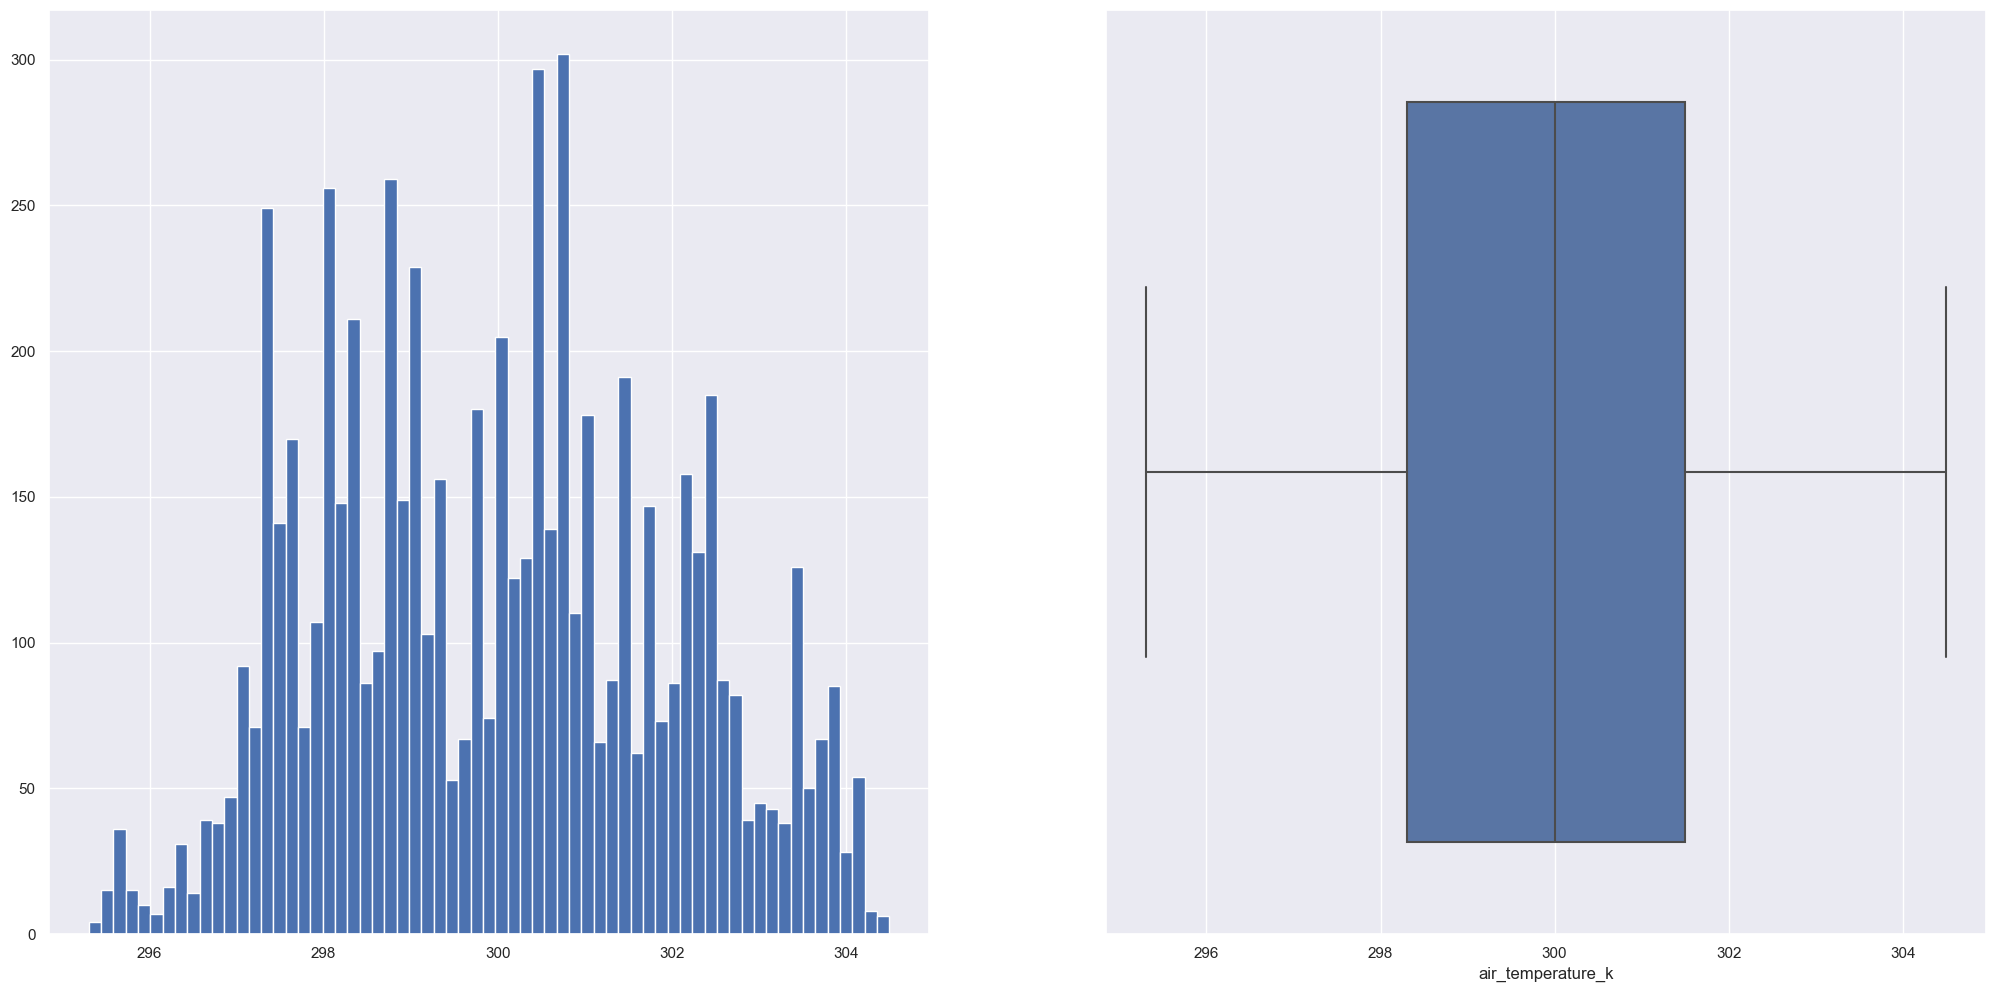

In [11]:
plt.subplot(1,2,1)
num_attribures['air_temperature_k'].hist(bins=65)
plt.subplot(1,2,2)
sns.boxplot(x=num_attribures['air_temperature_k'])

**process_temperature_k**

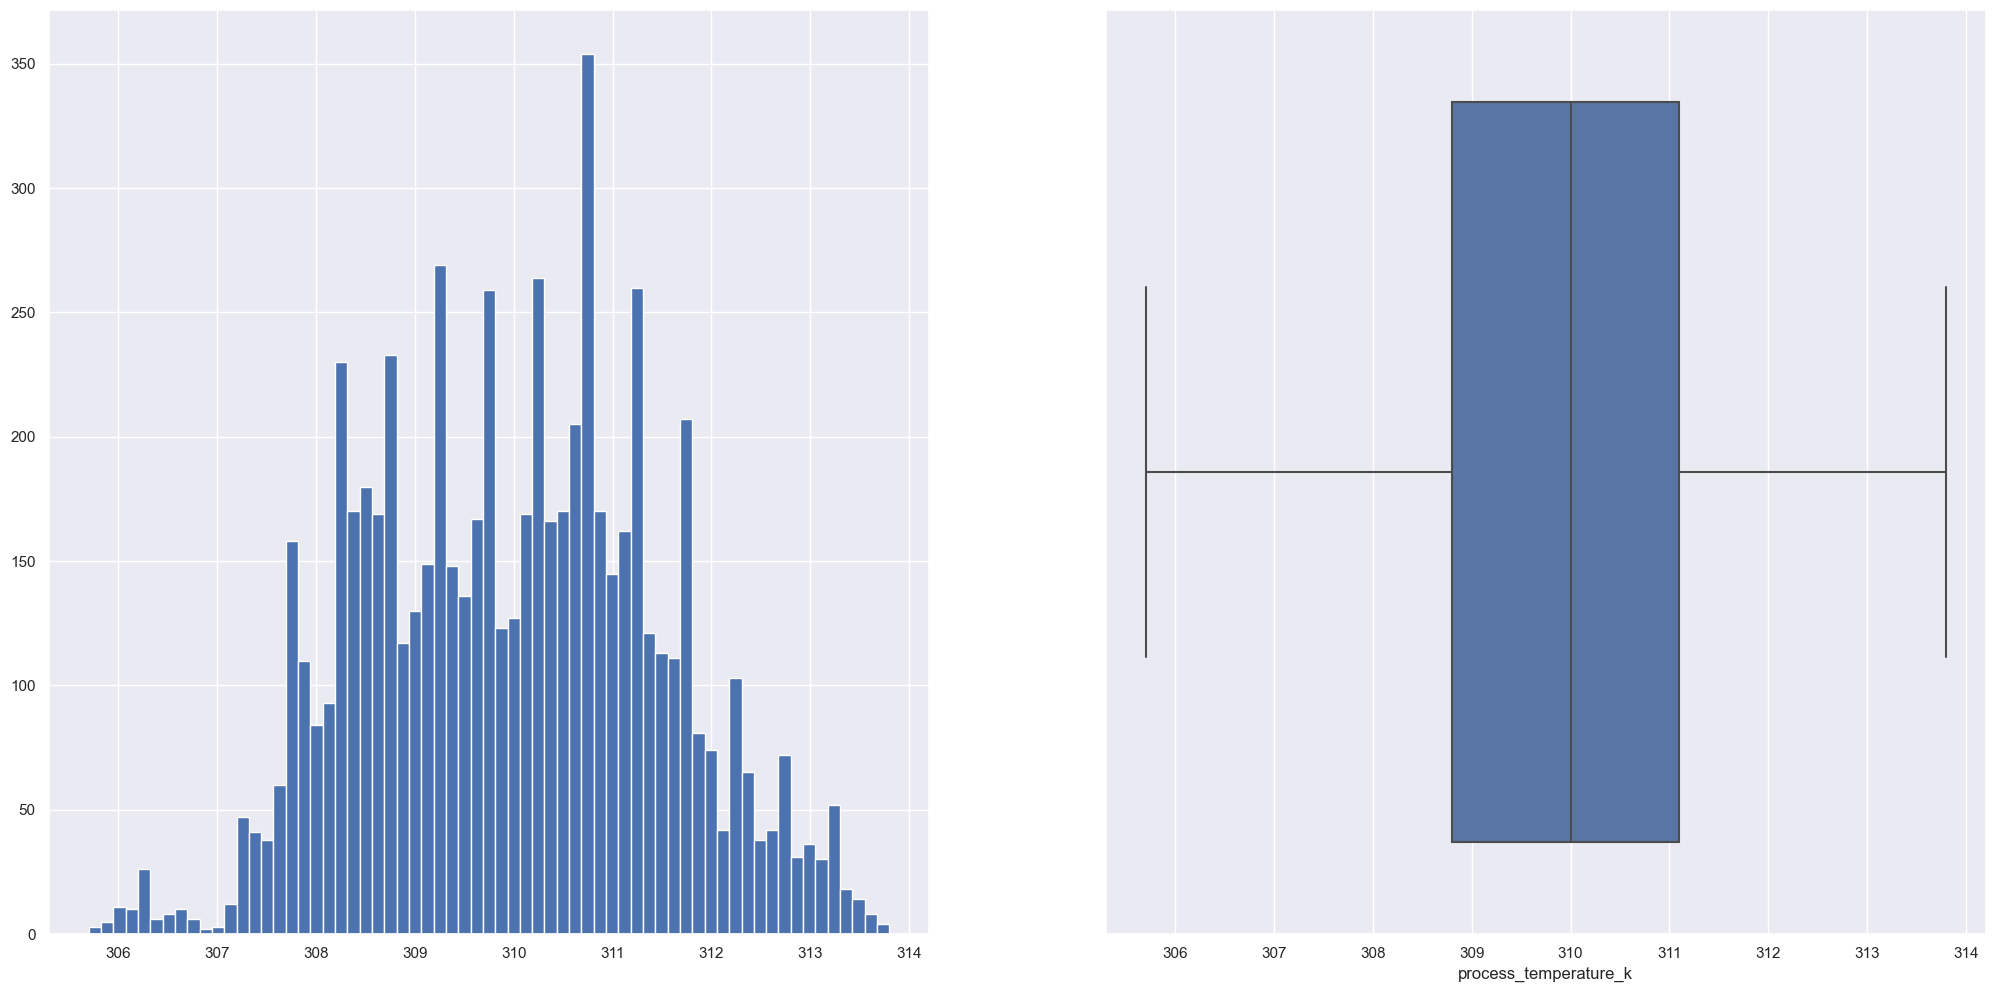

In [12]:
plt.subplot(1,2,1)
num_attribures['process_temperature_k'].hist(bins=65)
plt.subplot(1,2,2)
sns.boxplot(x=num_attribures['process_temperature_k']);

**rotational_speed_rpm**

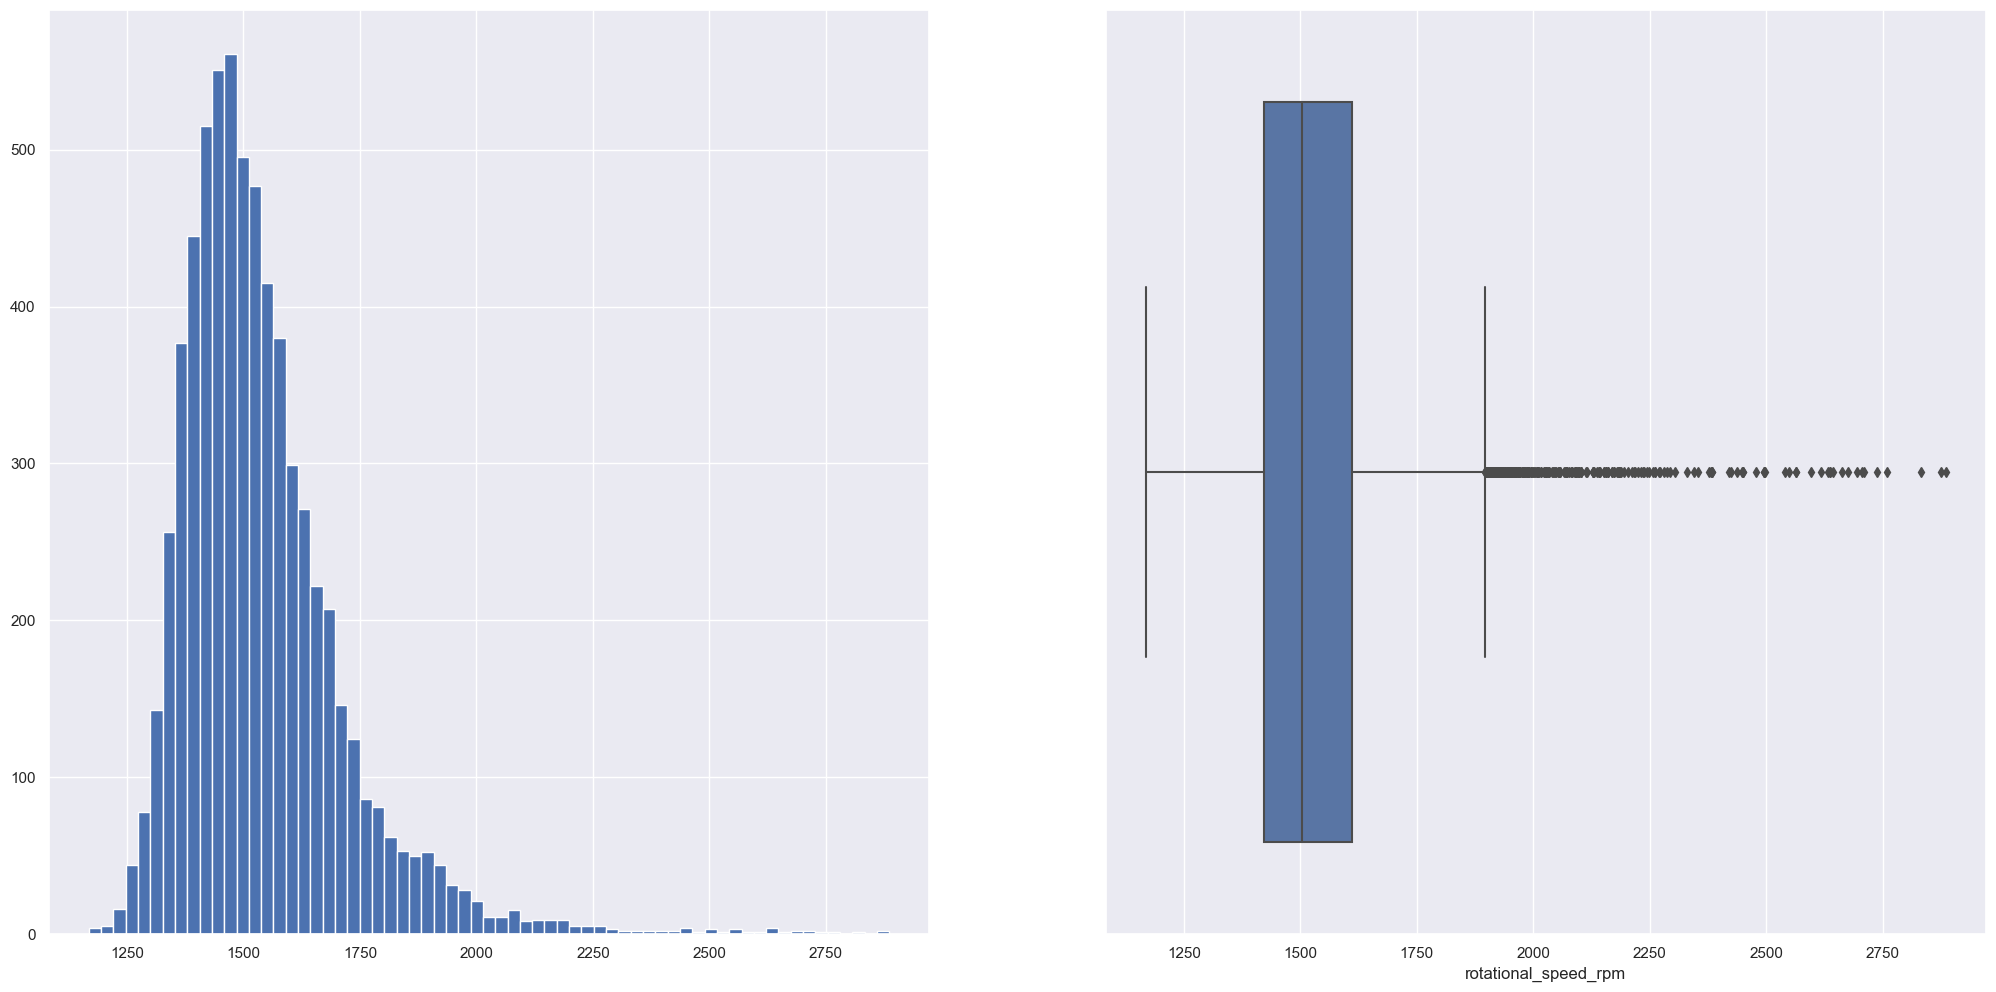

In [13]:
plt.subplot(1,2,1)
num_attribures['rotational_speed_rpm'].hist(bins=65)
plt.subplot(1,2,2)
sns.boxplot(x=num_attribures['rotational_speed_rpm']);

Os dados apresentam uma assimetria com uma calda alongada para a direita, e a presença de outliers. Embora os outliers não sejam significantes para uma exclusão, eles irão influenciar na escolha do tipo de re-escala que será aplicado ao atributo.

**torque_nm**

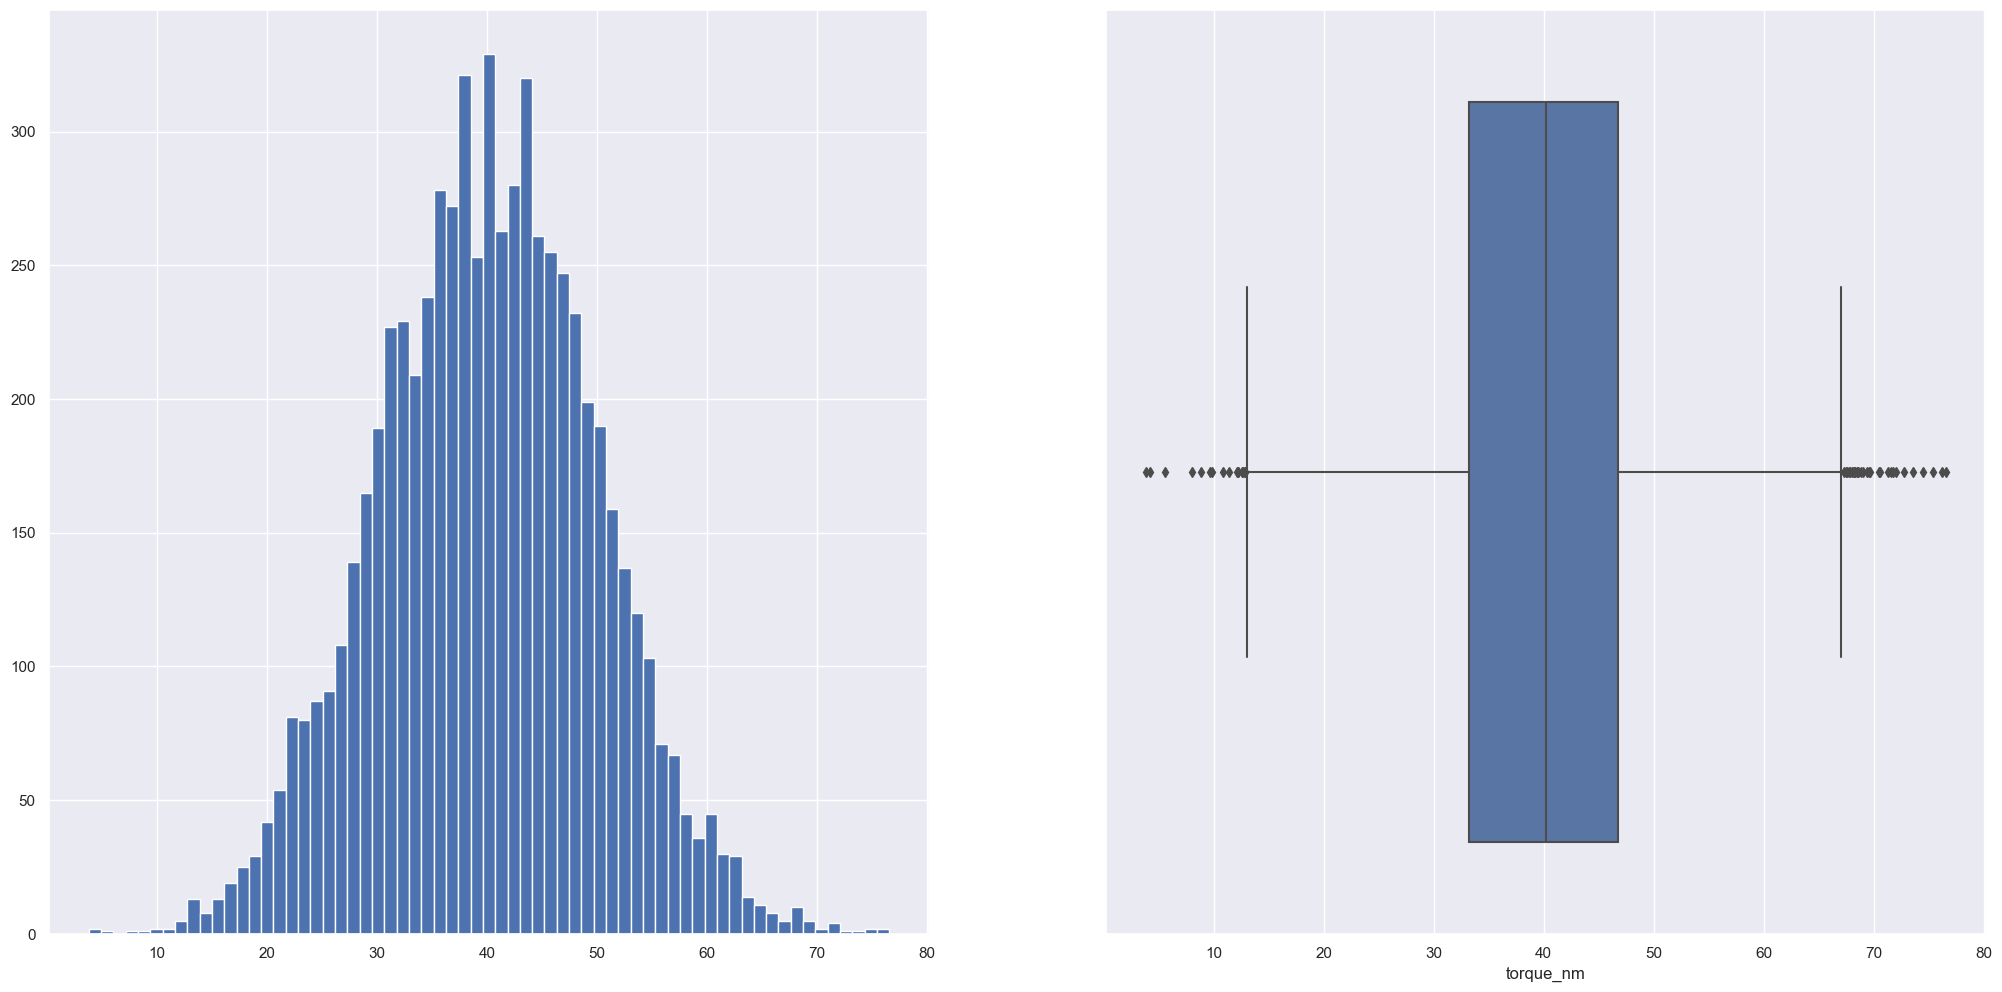

In [14]:
plt.subplot(1,2,1)
num_attribures['torque_nm'].hist(bins=65)
plt.subplot(1,2,2)
sns.boxplot(x=num_attribures['torque_nm']);

**tool_wear_min**

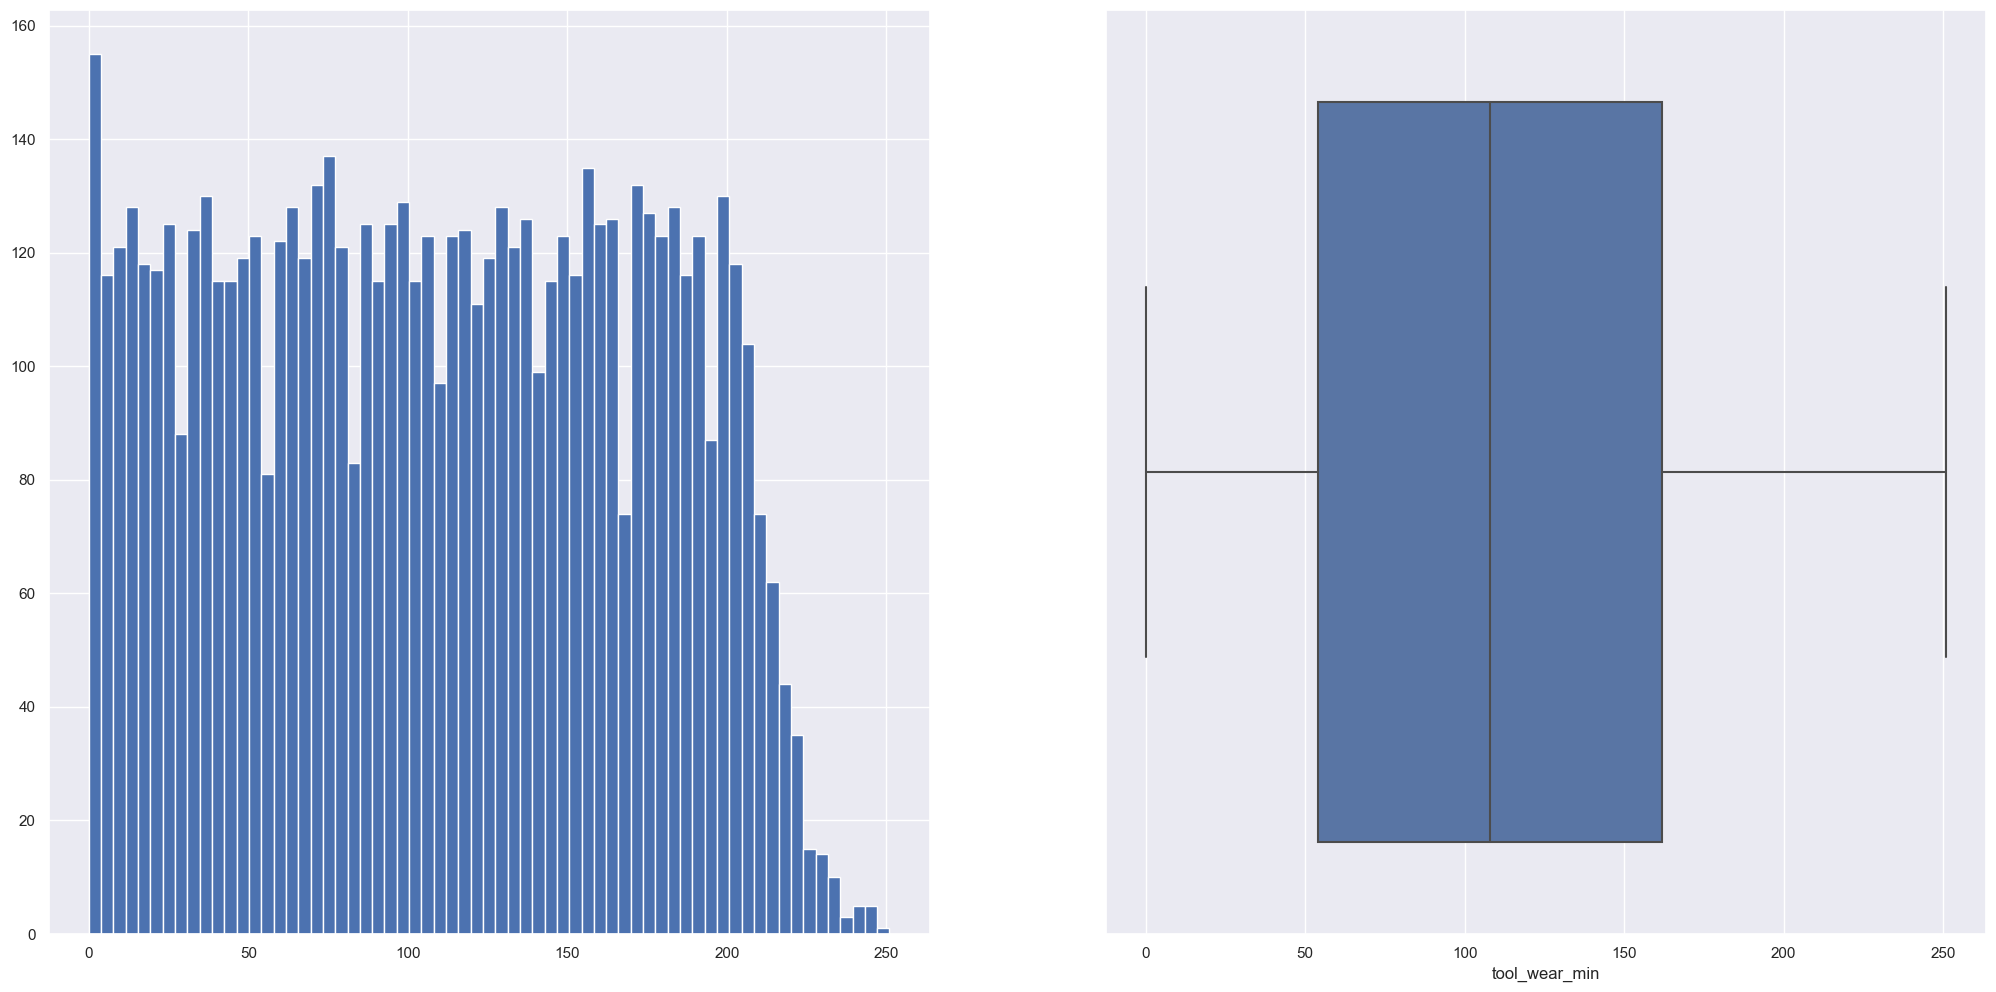

In [15]:
plt.subplot(1,2,1)
num_attribures['tool_wear_min'].hist(bins=65)
plt.subplot(1,2,2)
sns.boxplot(x=num_attribures['tool_wear_min']);

De todos os atributos numéricos é oque mais se distância na distribuição normal, mas no primeiro ciclo não será aplicado nenhum processo de normalização no atributo

## 2.1 categorical statistics

In [16]:
cat_attribures.apply(lambda x: x.unique().shape[0])

udi             6667
product_id      6667
type               3
failure_type       6
dtype: int64

Contagem das frequências dos componentes das variavéis categoricas, como as variaveis 'udi' e 'product_id' tem o mesma contagem que o tamanho do dataset, mostra que não possui identificadores duplicados

**Type**

<AxesSubplot: xlabel='type', ylabel='count'>

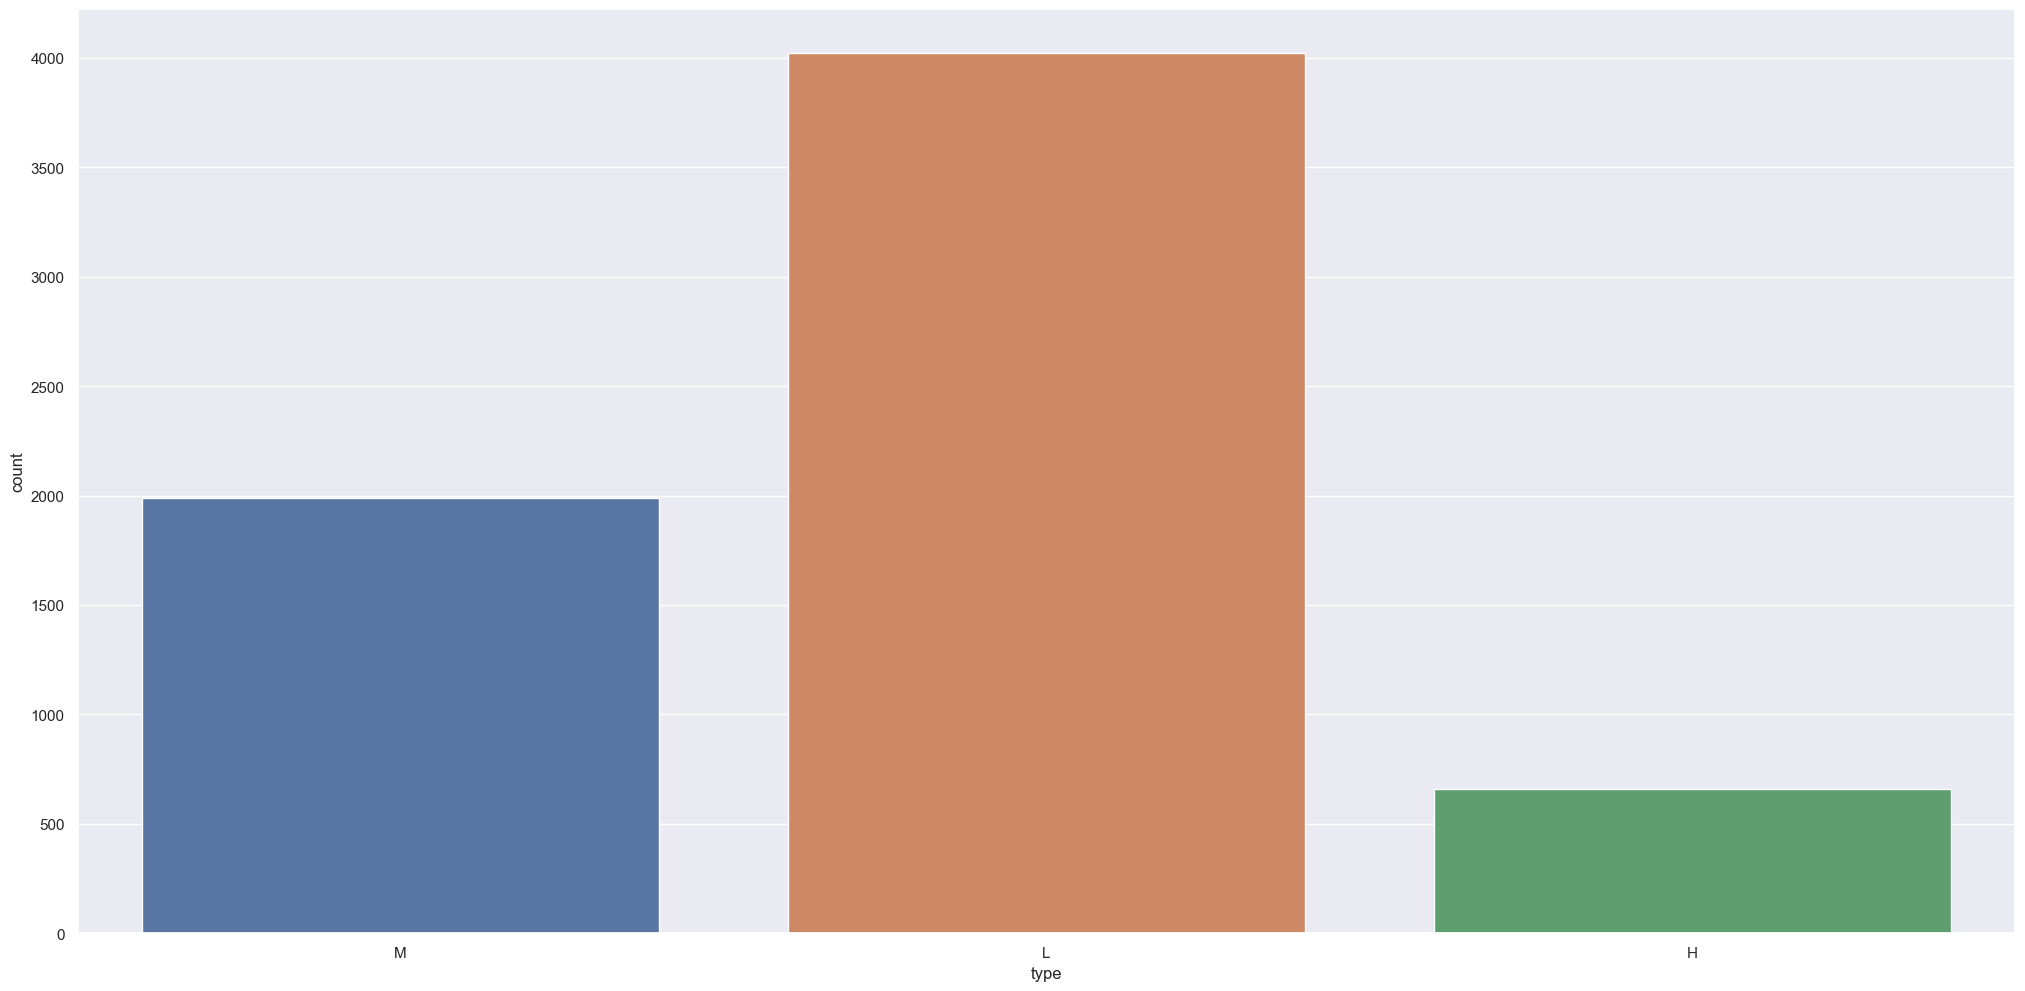

In [17]:
sns.countplot(x='type',data=cat_attribures)

In [18]:
cat_attribures['type'].value_counts(normalize=True)

L    0.603270
M    0.298035
H    0.098695
Name: type, dtype: float64

A variavel 'type' não possui uma distribuição simétrica dos componentes 

**Failure_type**

<AxesSubplot: xlabel='failure_type', ylabel='count'>

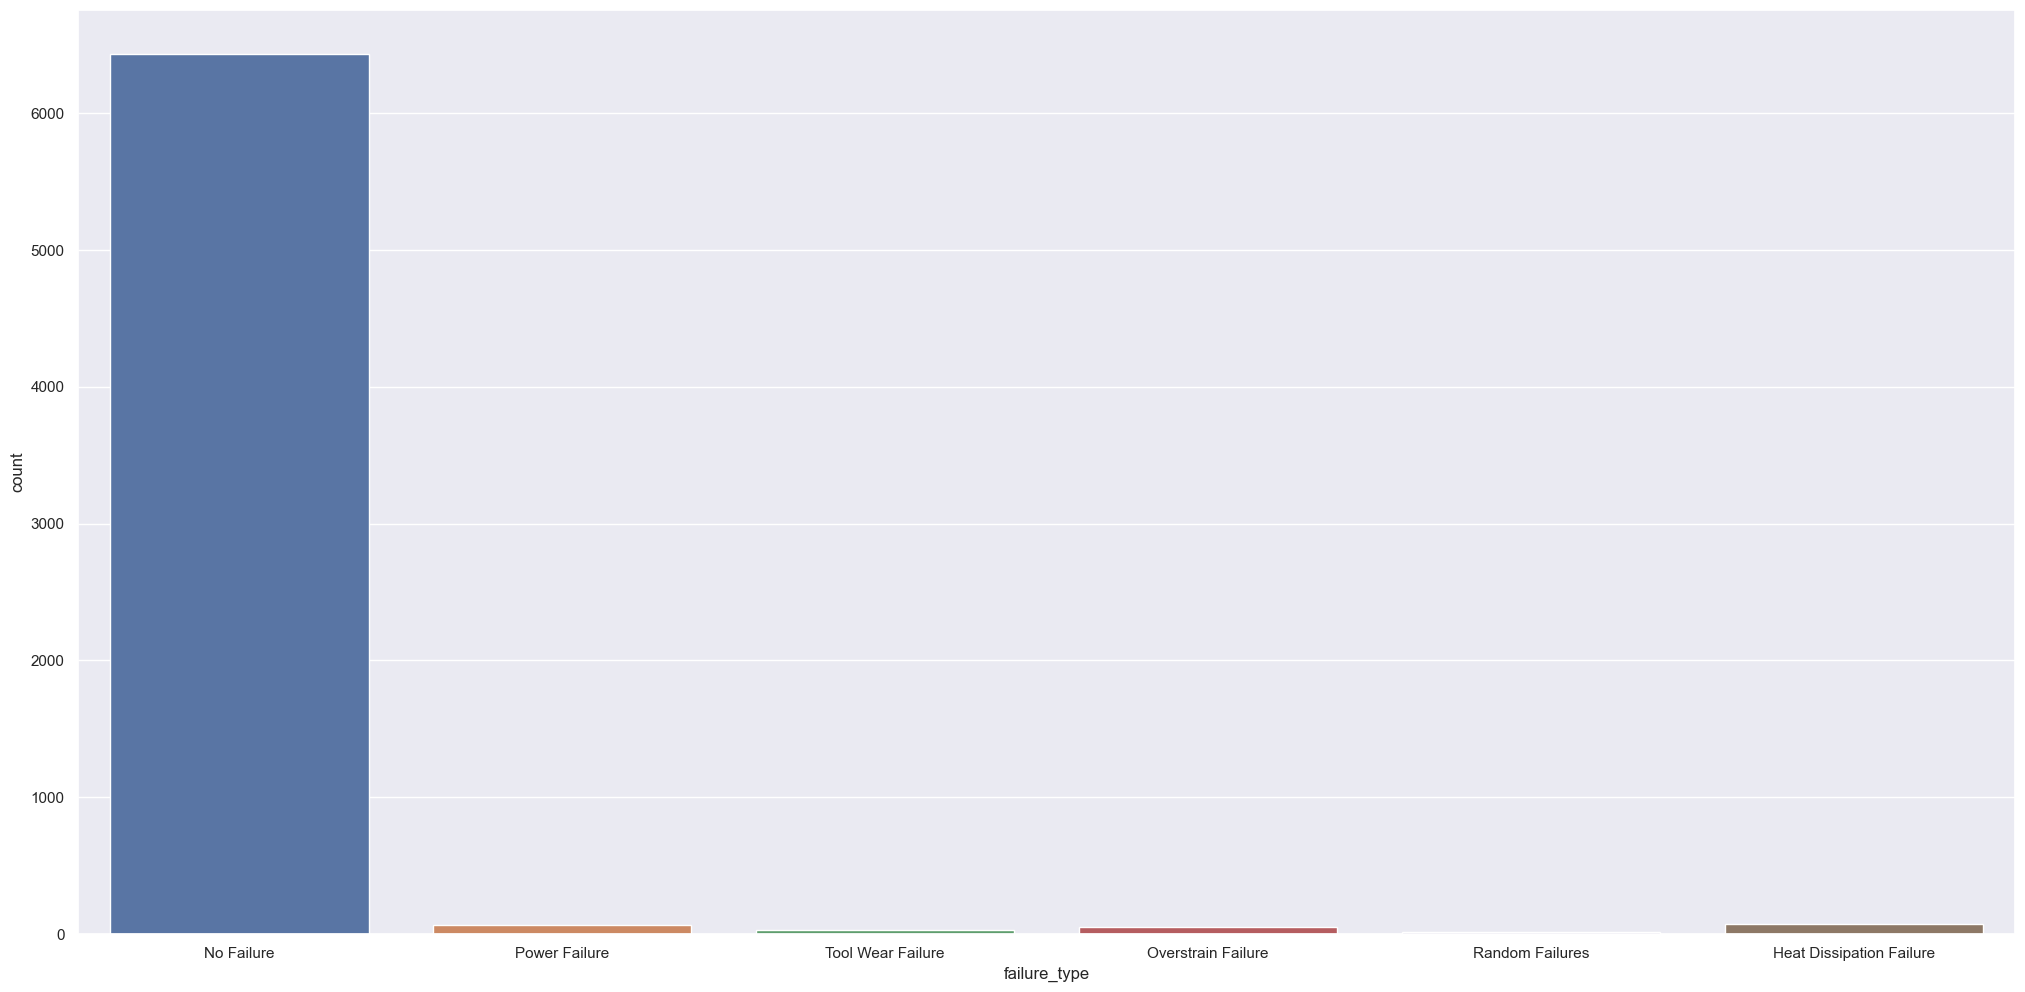

In [19]:
sns.countplot(x='failure_type',data=cat_attribures)

A variavel target 'failute_type' possui multiplas categorias

In [20]:
cat_attribures['failure_type'].value_counts(normalize=True)

No Failure                  0.965202
Heat Dissipation Failure    0.011249
Power Failure               0.009450
Overstrain Failure          0.007800
Tool Wear Failure           0.004500
Random Failures             0.001800
Name: failure_type, dtype: float64

Como existe uma categoria que representa quase 97% dos casos dentro de 'failure_type' estamos lidando com um desbalanceamento de classe

**Pela análise descritiva inicial, pode-se observar que o problema se trata de uma classificação multiclasse com desbalanceamento, onde não se encontrou nenhuma grande irregularidade nos dados**

# 3.0 Feature engineering

## 3.1 hyphotheses mind map

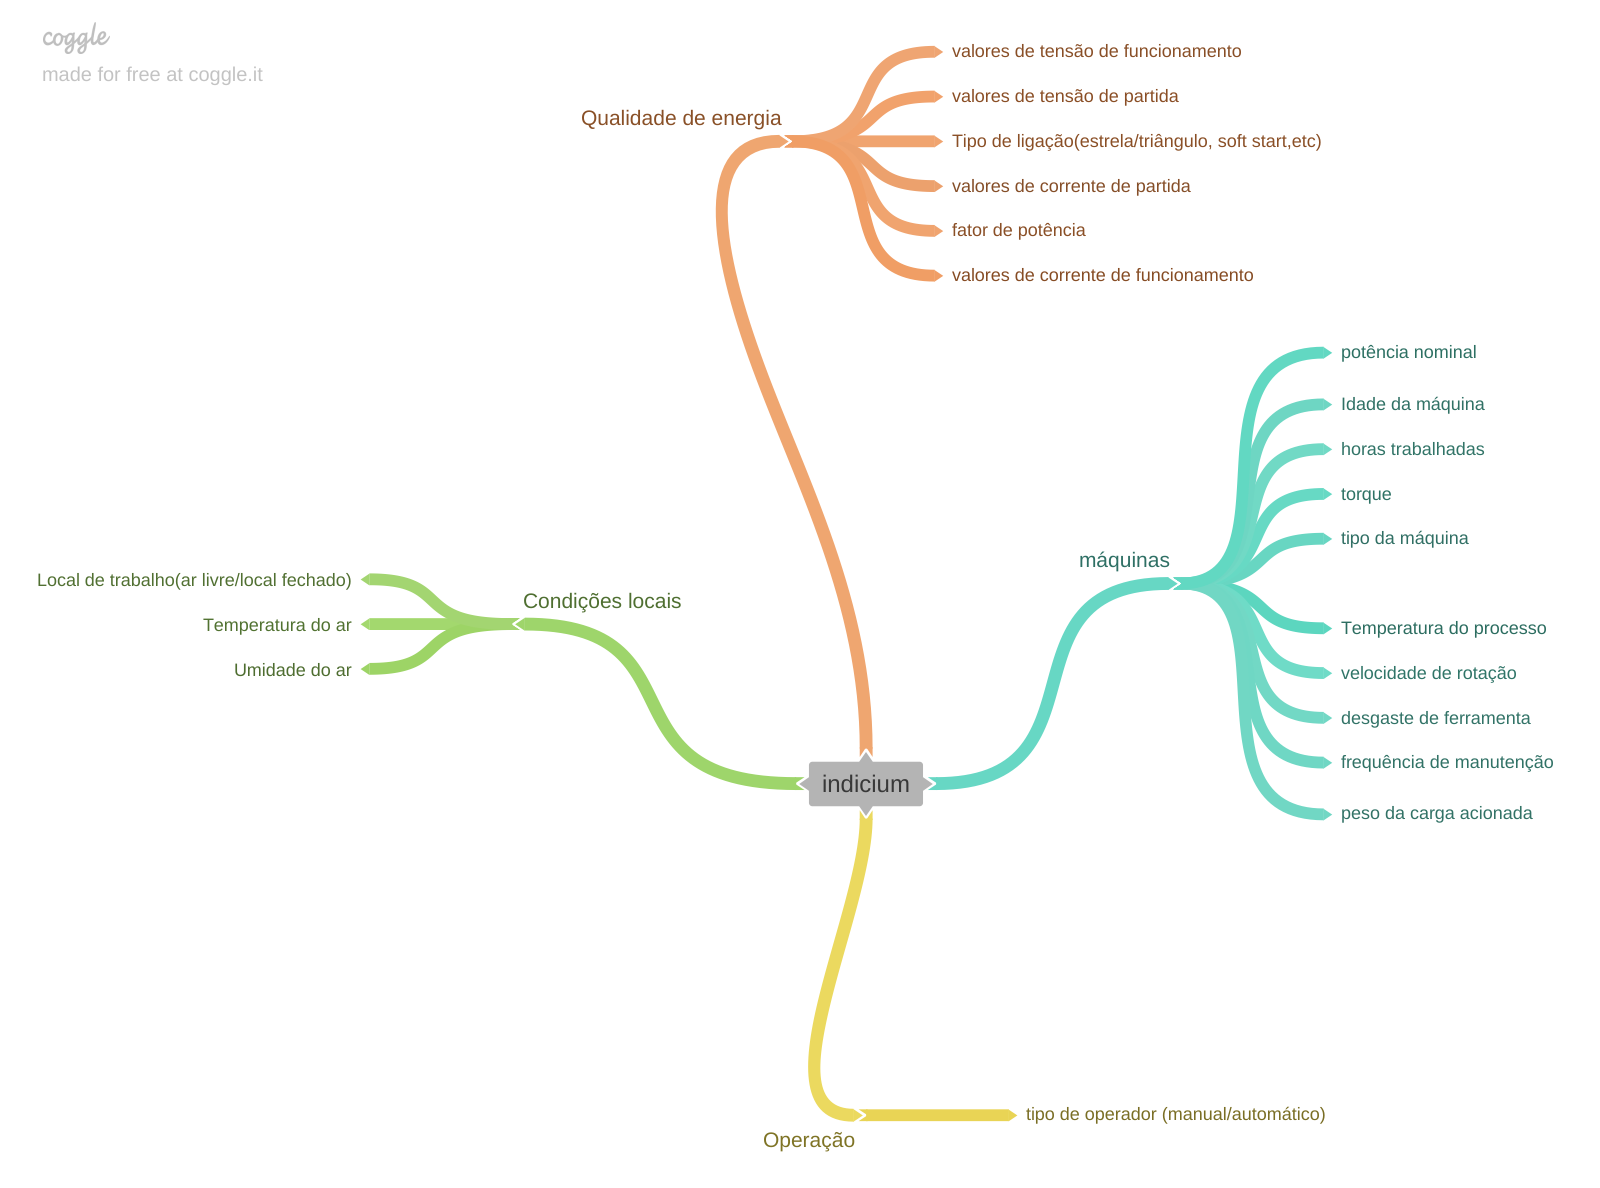

In [21]:
Image(path_local + 'data/images/indicium.png')

**Acima estão todas as variavéis que podem ajudar a explicar o fenômeno, infelizmente a maioria não está disponivel e as que possuimos não podem ser utilizadas para derivar as que faltam, então no momento iremos criar hipoteses com as existentes para melhor entender o comportamento das variáveis em relação a variavel 'failure_type'. Mas em ciclos futuros séra requisitado que esses outros atributos sejam monitorados.**

### 3.1.1 Hipoteses de condições locais

**h01: máquinas cuja a temparatura do ar está acima da mediana, apresentão 2x mais falha de dissipação de calor do que aquelas que estão abaixo da mediana**

### 3.1.2 Hipoteses de máquinas

**h02: Máquinas do tipo 'H' não apresentam falhas**

**h03: Máquinas do tipo 'l' apresentão falhas 3x mais que dos outros tipos somados**

**h04: máquinas cuja a temperatura do processo está acima da mediana, apresentão 2x mais falha de dissipação de calor do que aquelas que estão abaixo da mediana**

**h05: Máquinas que trabalham com rotação acima do 90 percentil apresentam mais falhar de qualquer tipo**

**h06: Máquinas que trabalham com rotação acima do 80 percentil apresentão mais falhas de sobrecarga**

**h07: Máquinas que trabalham com torque acima do 95 percentil apresentão mais falhas de energia**

**h08: Máquinas que apresentão falhar de energia possuem alto torque e baixa rotação**

**h09: Máquinas que trabalham com todos os atributos abaixo da mediana não apresentam falhas**

**h010: Máquinas que trabalham desgaste de ferramenta acima do 70. percentil apresentão mais falha de desgaste**

## 3.2 Feature engineering

**No ciclo inical não será criado nenhuma nova feature**

## 3.3 Variable Filtering

**A descrição inical dos dados não demostrou nenhum necessidade de limpeza**

#  4.0 EDA

**Analise mais afunda dos atributos para definir seu comportamento com a variável target e quais são mais importantes para o modelo**

## Análise univariada

In [22]:
df_uni = df1[['type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type']]

In [23]:
num_statistics

,min,max,mean,median,std,skew,kurtosis,range
air_temperature_k,295.3,304.5,299.992515,300.0,1.994710,0.126800,-0.819938,9.2
process_temperature_k,305.7,313.8,309.992620,310.0,1.488101,0.016152,-0.508652,8.1
rotational_speed_rpm,1168.0,2886.0,1537.419529,1503.0,177.182908,1.952833,7.310365,1718.0
torque_nm,3.8,76.6,40.058512,40.2,9.950804,0.011572,0.008249,72.8
tool_wear_min,0.0,251.0,108.098095,108.0,63.359915,0.019810,-1.157345,251.0


In [24]:
df_uni.groupby('failure_type').mean()

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\1281247588.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_uni.groupby('failure_type').mean()


,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
failure_type,,,,,
Heat Dissipation Failure,302.550667,310.776000,1338.946667,52.493333,110.773333
No Failure,299.961756,309.981943,1539.159751,39.693986,106.737840
Overstrain Failure,299.955769,310.073077,1358.557692,56.336538,209.865385
Power Failure,299.888889,309.873016,1712.857143,51.080952,106.587302
Random Failures,300.691667,310.691667,1492.416667,43.608333,118.583333
Tool Wear Failure,300.196667,310.156667,1619.933333,34.380000,215.766667


In [25]:
df_uni.groupby('failure_type').median()

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\2907740100.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_uni.groupby('failure_type').median()


,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
failure_type,,,,,
Heat Dissipation Failure,302.50,310.70,1349.0,52.20,112.0
No Failure,300.00,310.00,1507.0,39.90,106.0
Overstrain Failure,299.45,310.10,1367.5,55.95,208.0
Power Failure,299.90,310.10,1386.0,65.30,102.0
Random Failures,300.65,311.20,1473.0,44.95,150.0
Tool Wear Failure,300.40,310.55,1547.5,36.60,214.5


**A média e mediana se mantém semelhantes na maioria dos casos quando agrupamos os atributos por tipo de falha. os que apresentam valores acima da média e mediana geral pode ser o indicador da tendência de falha**

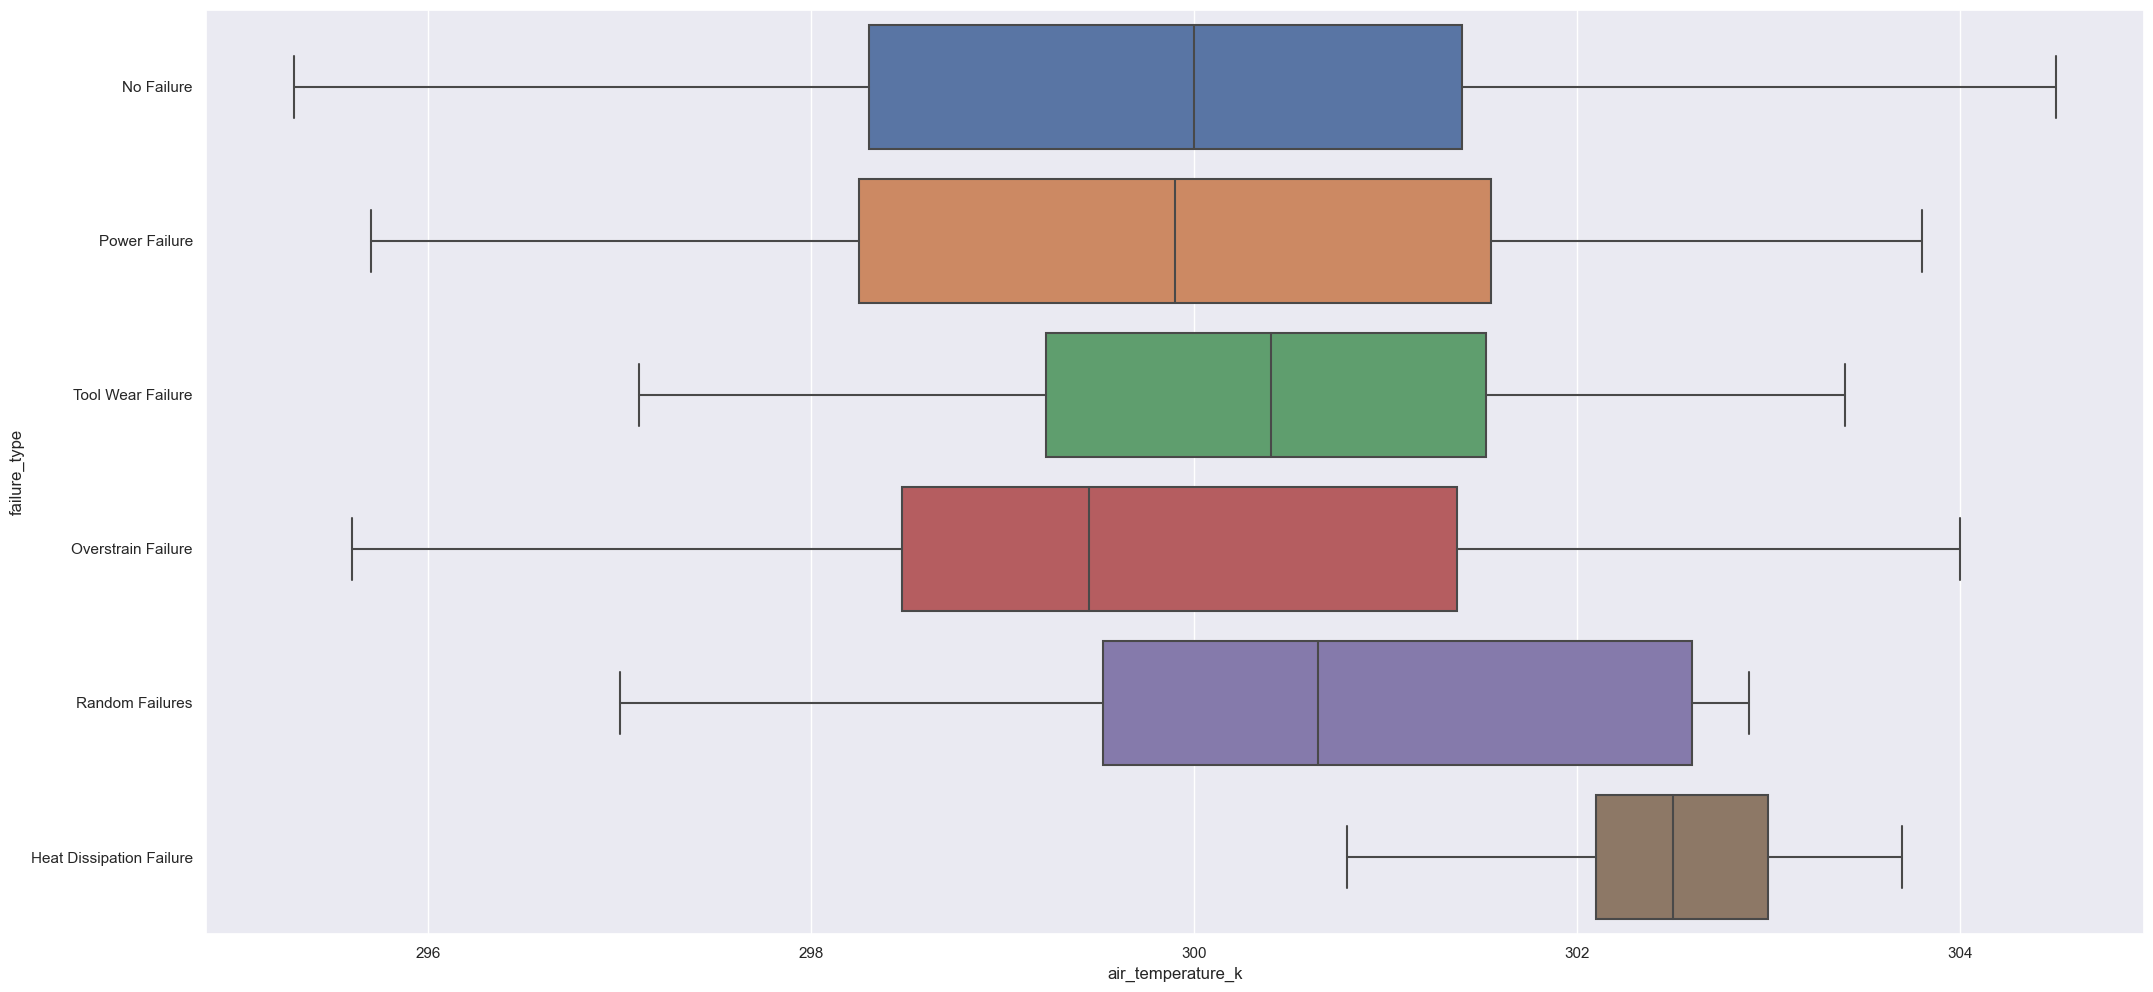

In [26]:
sns.boxplot(data=df_uni[['air_temperature_k','failure_type']],x='air_temperature_k',y='failure_type');

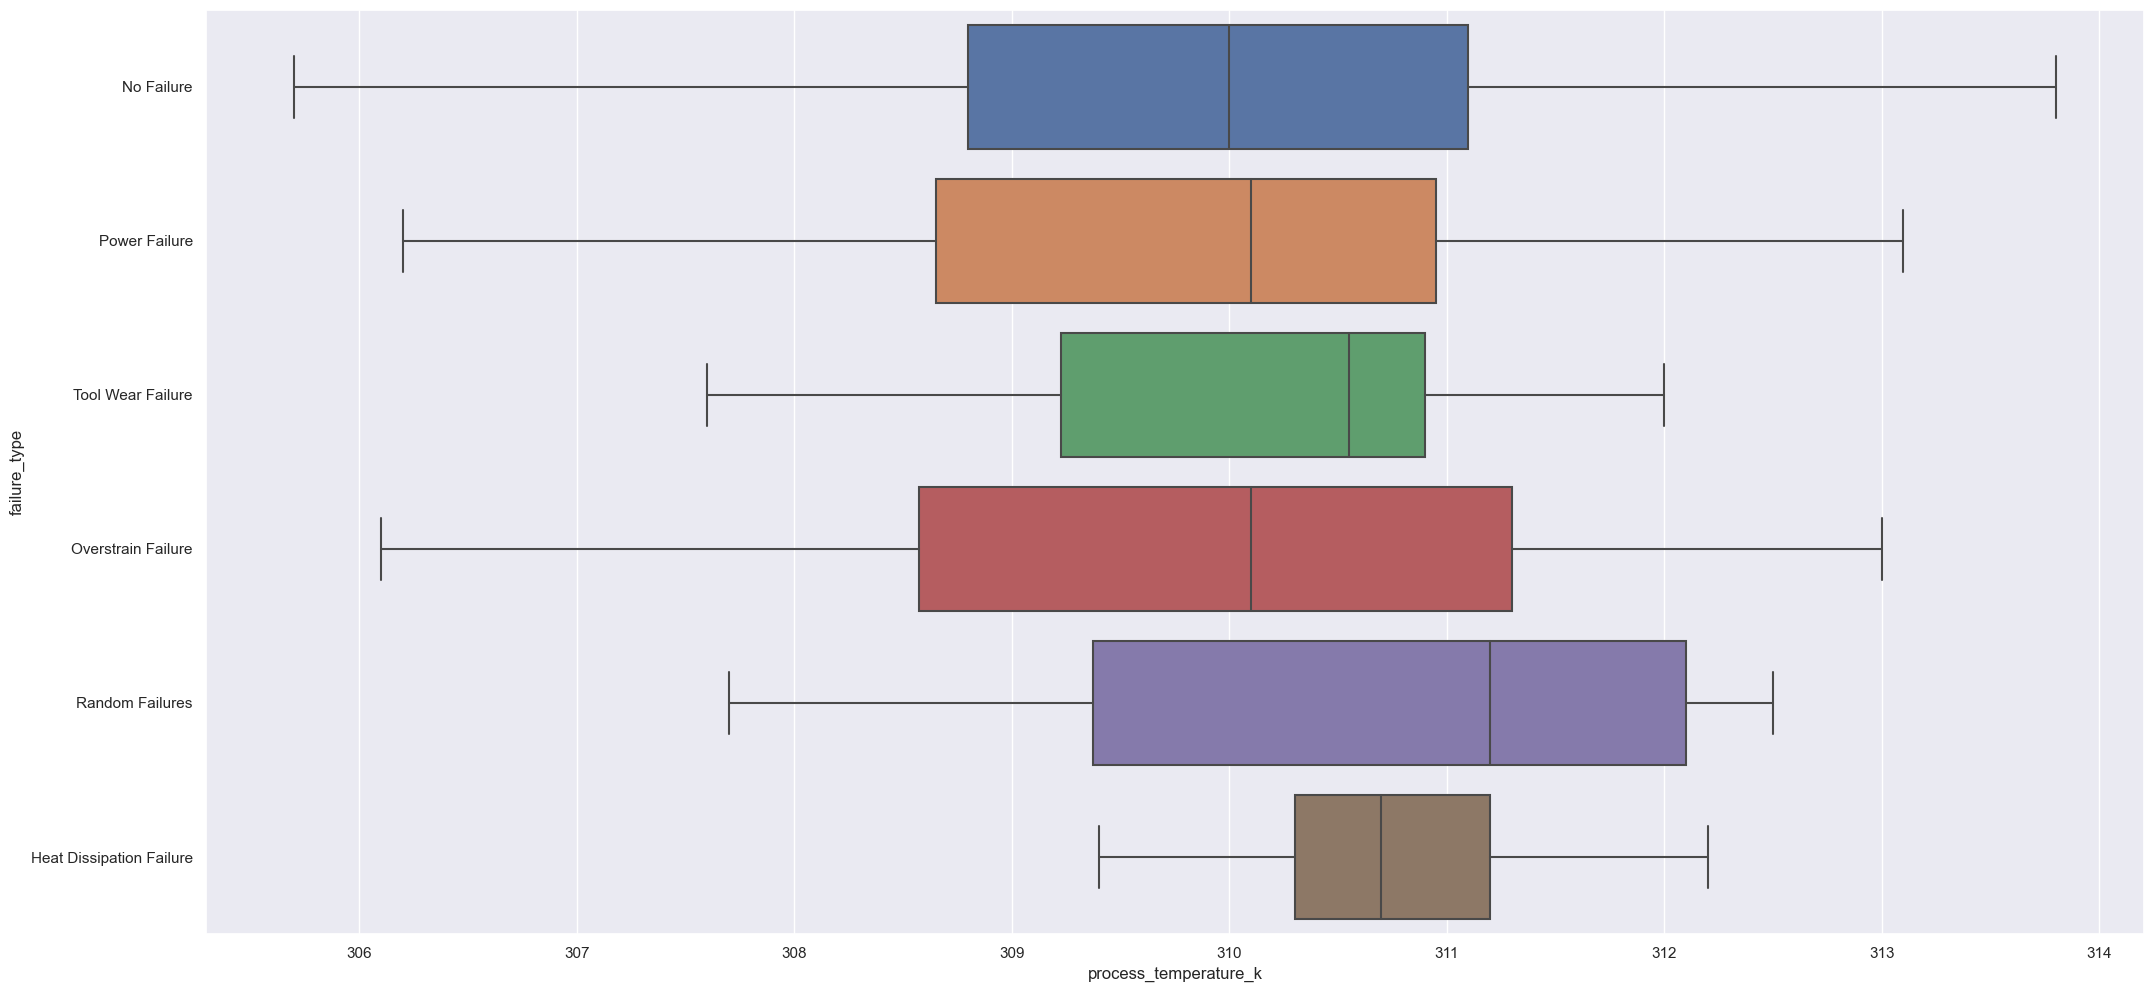

In [27]:
sns.boxplot(data=df_uni[['process_temperature_k','failure_type']],x='process_temperature_k',y='failure_type');

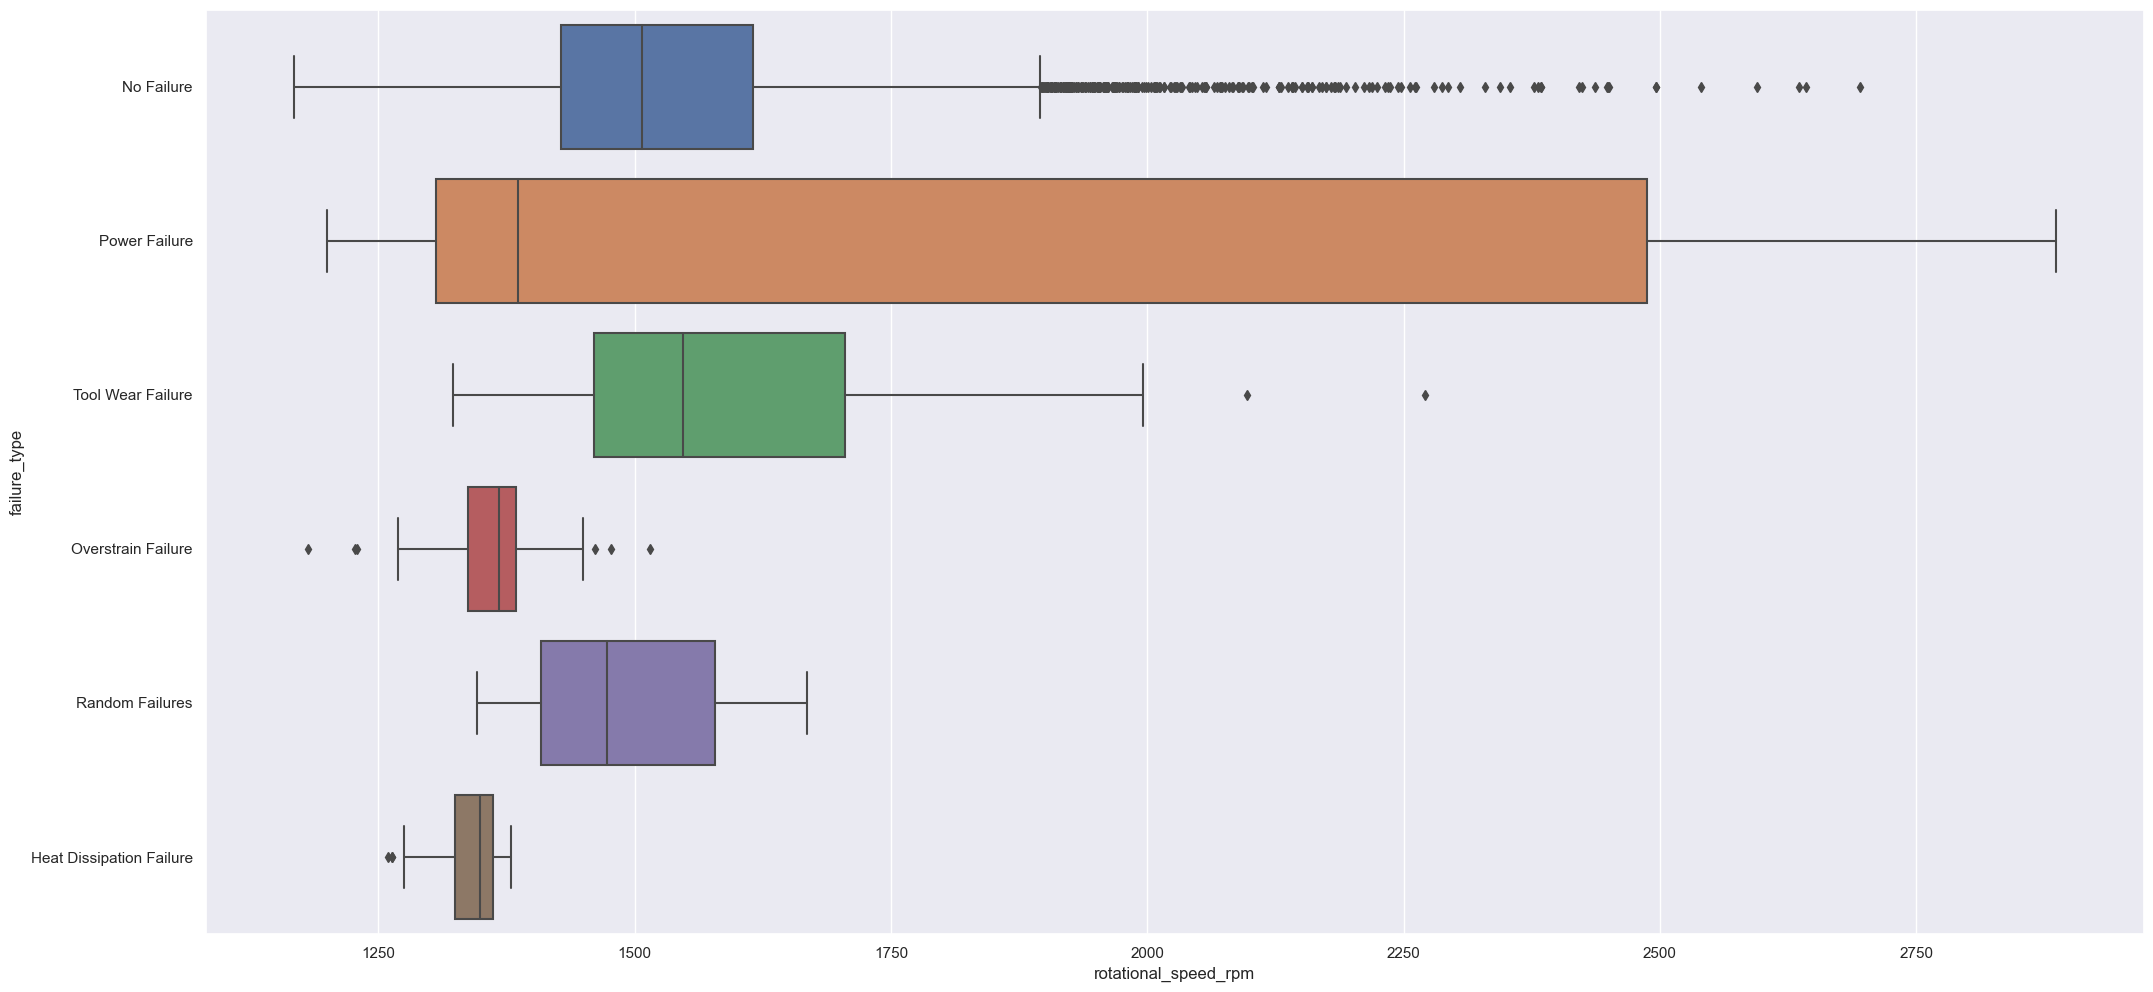

In [28]:
sns.boxplot(data=df_uni[['rotational_speed_rpm','failure_type']],x='rotational_speed_rpm',y='failure_type');

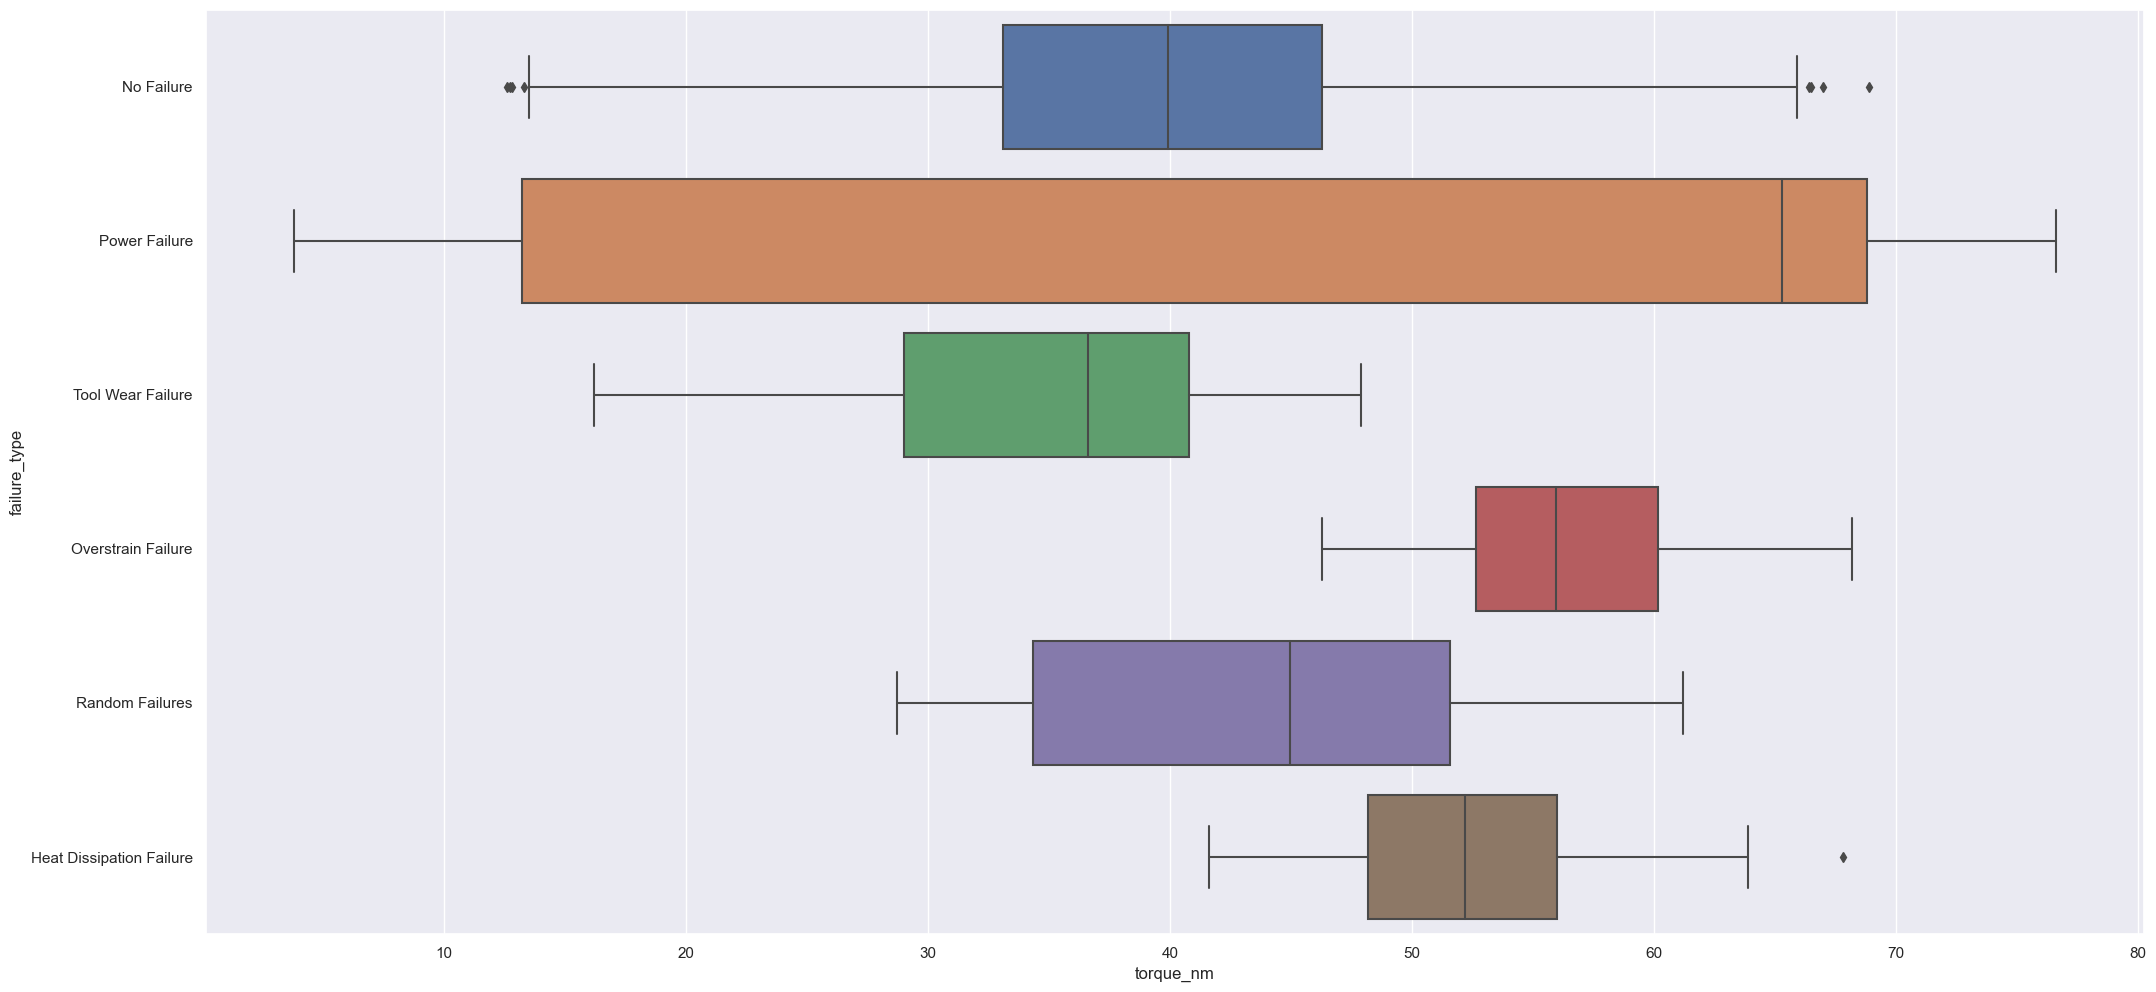

In [29]:
sns.boxplot(data=df_uni[['torque_nm','failure_type']],x='torque_nm',y='failure_type');

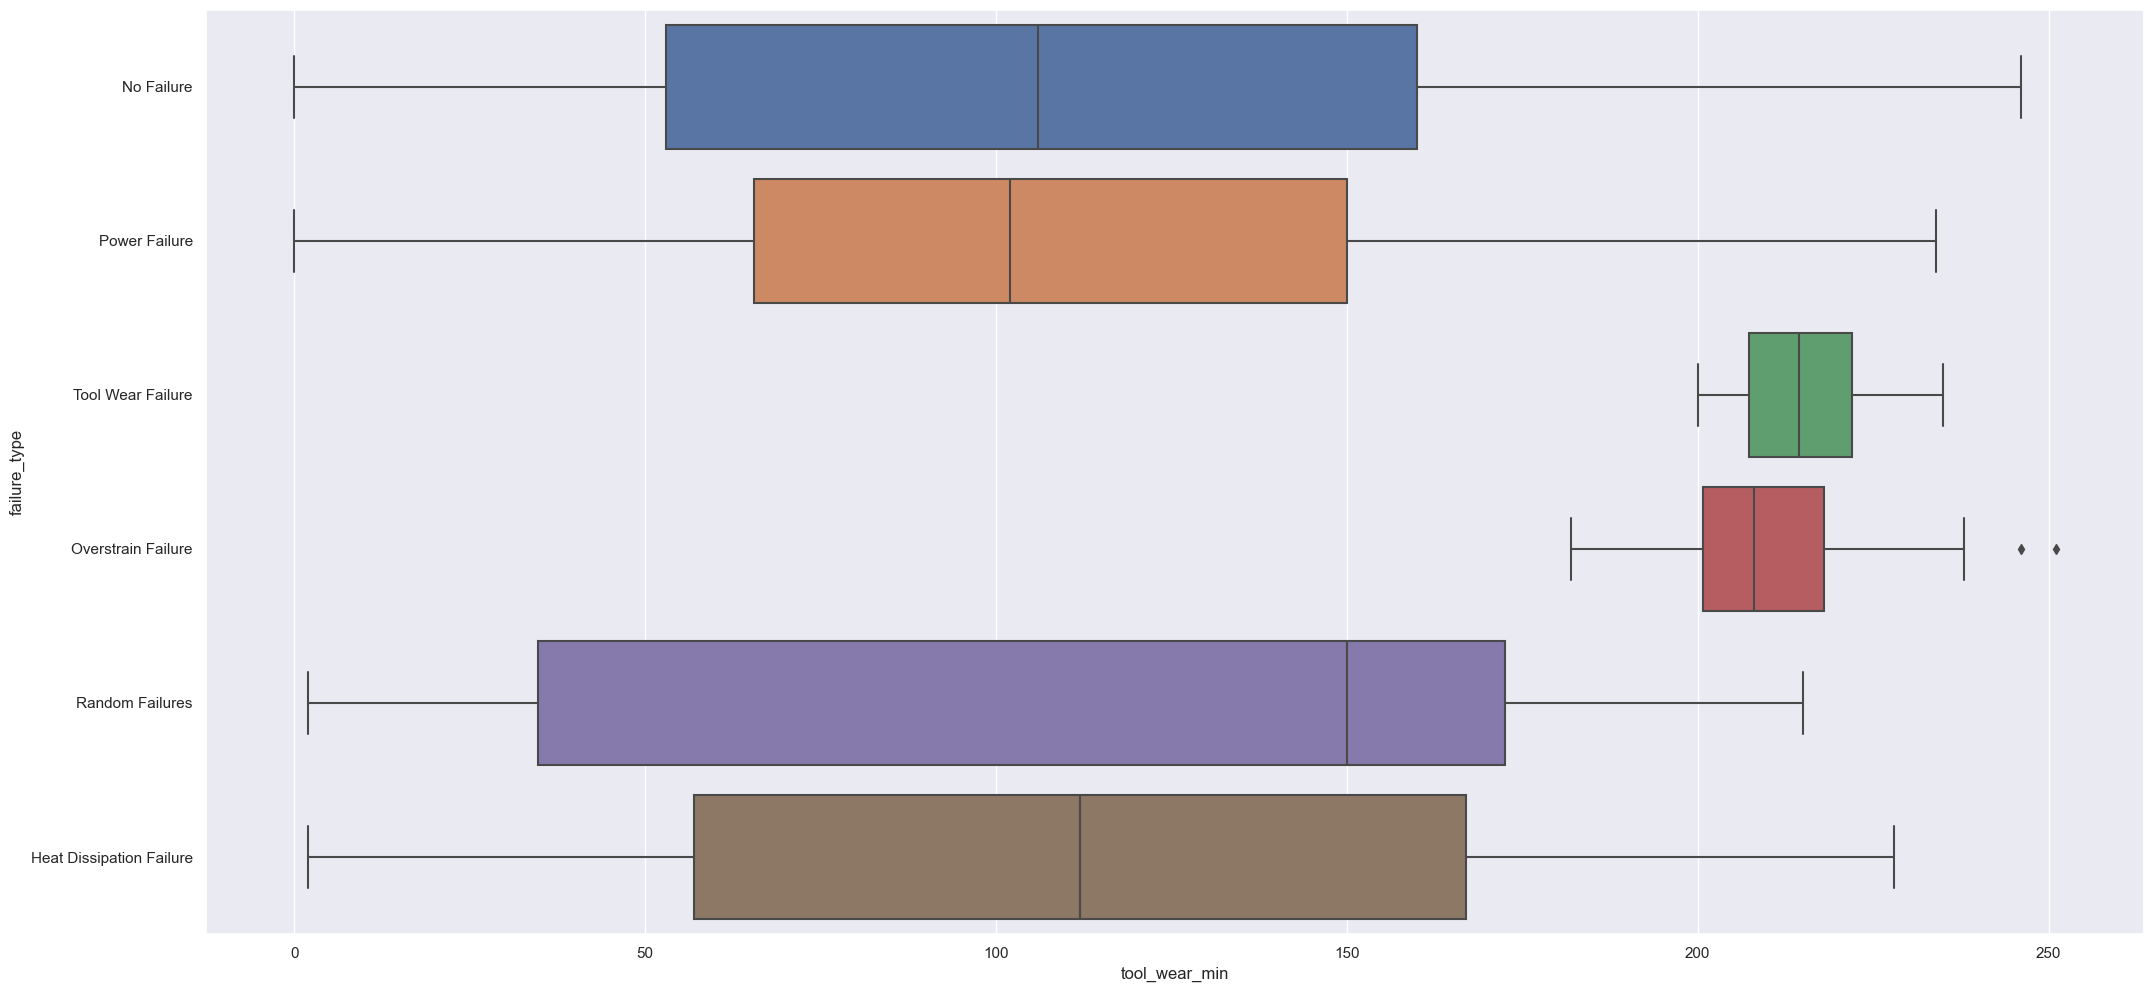

In [30]:
sns.boxplot(data=df_uni[['tool_wear_min','failure_type']],x='tool_wear_min',y='failure_type');

**Com os gráficos é possivel observar quais atributos se relacionam mais com os tipos de falhas, como todos tem certa relação com as falhas provavelmente não serão excluidos para o treino do modelo**

In [31]:
df_uni[['type','failure_type']].groupby(['failure_type','type']).size().reset_index()

,failure_type,type,0
0,Heat Dissipation Failure,H,7
1,Heat Dissipation Failure,L,46
2,Heat Dissipation Failure,M,22
3,No Failure,H,641
4,No Failure,L,3861
5,No Failure,M,1933
6,Overstrain Failure,H,1
7,Overstrain Failure,L,50
8,Overstrain Failure,M,1
9,Power Failure,H,4


<AxesSubplot: xlabel='failure_type', ylabel='count'>

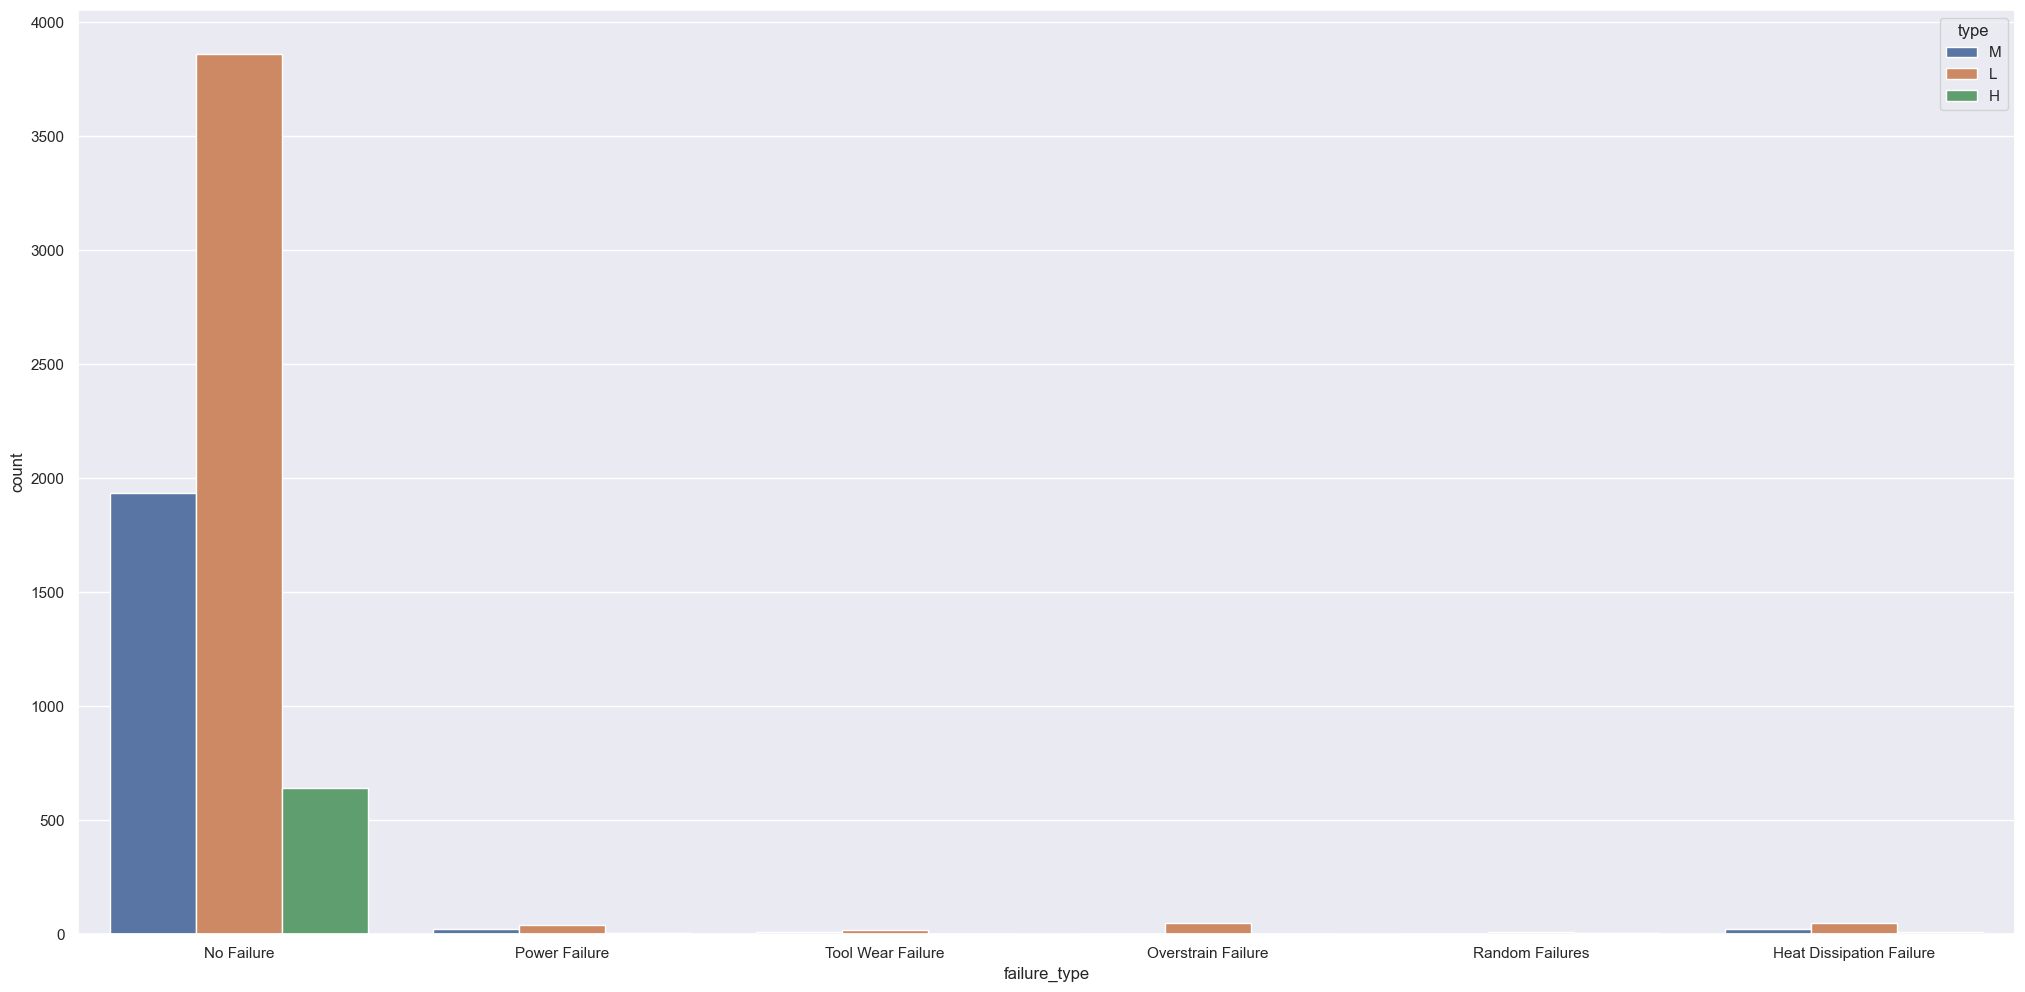

In [32]:
sns.countplot(x='failure_type',hue='type',data=df_uni)

**É possivel notar que todos os tipo de falhas possuem os três tipos de máquinas, então a qualidade da máquina não obrigatoriamente impossibilita ela de ter falhas**

## Análise bivariada

**Teste de hipoteses para aprofundar a analise do comportamento dos atributos e observar padrões que já possam ser repassados pros outros times tomarem decisões**

###  h01: máquinas cuja a temparatura do ar está acima da mediana, apresentão 2x mais falha de dissipação de calor do que aquelas que estão abaixo da mediana

In [33]:
#criadno dataframe com os dados significantes para a hipotese
h1 = df1[['air_temperature_k','failure_type']]
median_air = h1['air_temperature_k'].median()

# seperando conforme valores abaixo e cami da mediana
aux_a = h1[h1['air_temperature_k']>median_air]['failure_type'].value_counts()
aux_b = h1[h1['air_temperature_k']<median_air]['failure_type'].value_counts()

#transformando em dataframe
aux1_df = aux_a.to_frame(name='quantity_above_median').reset_index()
aux1_df.columns = ['failure_type','quantity_above_median']

aux2_df = aux_b.to_frame(name='quantity_below_median').reset_index()
aux2_df.columns = ['failure_type','quantity_below_median']

# unindo os dataframes para compara os valores 
aux = pd.merge(aux1_df, aux2_df, on='failure_type', how='left')
aux

,failure_type,quantity_above_median,quantity_below_median
0,No Failure,3172,3166.0
1,Heat Dissipation Failure,75,NaN
2,Power Failure,31,32.0
3,Overstrain Failure,25,27.0
4,Tool Wear Failure,17,12.0
5,Random Failures,8,4.0


<AxesSubplot: xlabel='failure_type', ylabel='value'>

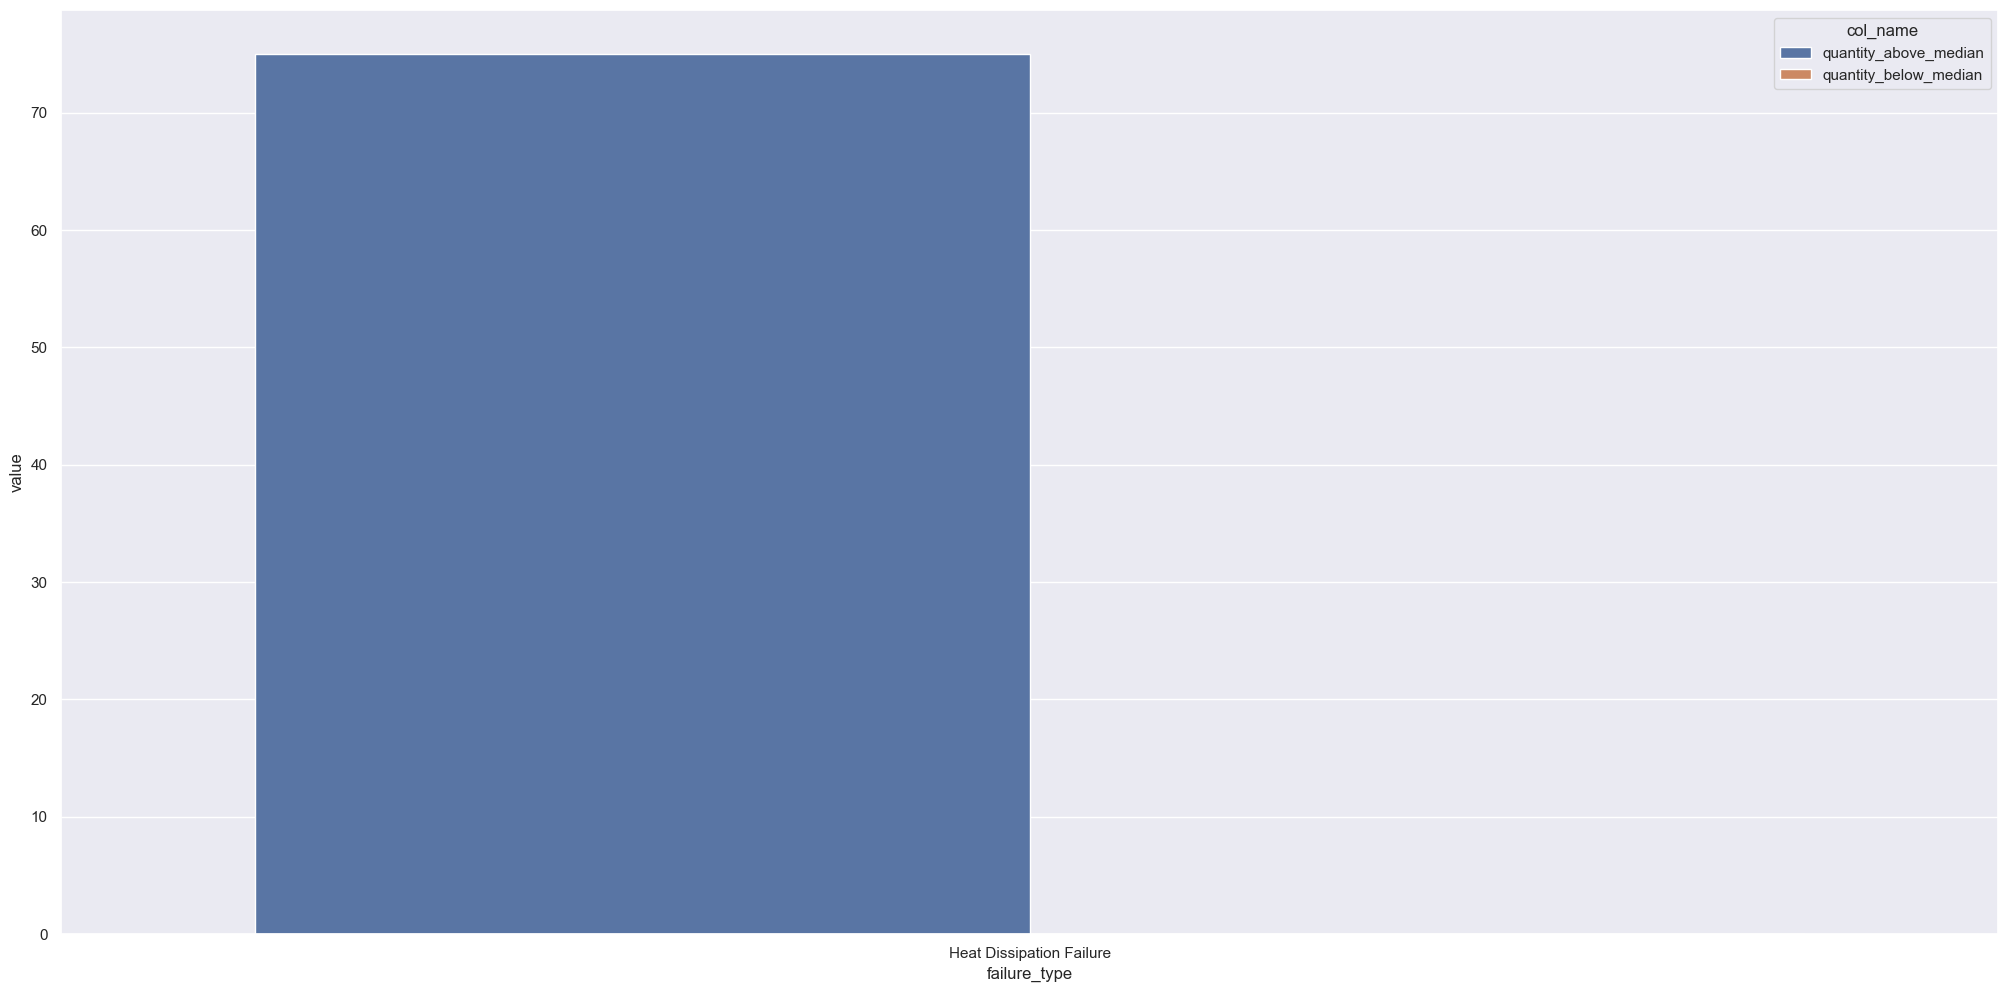

In [34]:
aux.fillna(value=0,inplace=True)
melted = aux.melt(id_vars='failure_type', value_vars=['quantity_above_median', 'quantity_below_median'], var_name='col_name', value_name='value')
sns.barplot(x='failure_type', y='value', hue='col_name', data=melted[melted['failure_type'] == 'Heat Dissipation Failure'])

**Falso, máquina que estão o ar está com temperatura abaixo da mediana não possuem falhar de aquecimento, mostrando a importância da variável para classificar falara de aquecimento**

### h02: Máquinas do tipo 'H' não apresentam falhas

In [35]:
h2 = df1.loc[df1['type']=='H','failure_type']

In [36]:
h2.value_counts()

No Failure                  641
Heat Dissipation Failure      7
Power Failure                 4
Random Failures               4
Overstrain Failure            1
Tool Wear Failure             1
Name: failure_type, dtype: int64

In [37]:
aux = list(h2.value_counts())

In [38]:
(1- (aux[0]/sum(aux)))*100

2.583586626139822

**Falso, 2.6% dos máquinas do tipo H possuem falhas, então mesmas as maquinas de alta qualidade apresentam falhas**

### h03: Máquinas do tipo 'L' apresentão falhas 3x mais que dos outros tipos somados

In [39]:
h3 = df1[['type','failure_type']]
aux_func = lambda x: 0 if x == 'No Failure' else 1
h3['failure'] = h3['failure_type'].apply(aux_func)

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\2354956574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h3['failure'] = h3['failure_type'].apply(aux_func)


In [40]:
h3 = h3.groupby(['type','failure']).size().reset_index()
h3 = h3[h3['failure']==1]

In [41]:
L = int(h3[h3['type']=='L'][0])
H = int(h3[h3['type']=='H'][0])
M = int(h3[h3['type']=='M'][0])

In [42]:
L/(H+M)

2.267605633802817

**Falso, Máquinas do tipo 'L' não paresentam 3 vezes mais falhar que os outros somados, mas apresenta 2.27 vezes mais oque ainda é significativo**

### h04: máquinas cuja a temperatura do processo está acima da mediana, apresentão 2x mais falha de dissipação de calor do que aquelas que estão abaixo da mediana

In [43]:
df1.columns

Index(['udi', 'product_id', 'type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type'],
      dtype='object')

In [44]:
#criando dataframe com os dados significantes para a hipotese
h4 = df1[['process_temperature_k','failure_type']]
median_air = h4['process_temperature_k'].median()

# seperando conforme valores abaixo e cami da mediana
aux_a = h4[h4['process_temperature_k']>median_air]['failure_type'].value_counts()
aux_b = h4[h4['process_temperature_k']<median_air]['failure_type'].value_counts()

#transformando em dataframe
aux1_df = aux_a.to_frame(name='quantity_above_median').reset_index()
aux1_df.columns = ['failure_type','quantity_above_median']

aux2_df = aux_b.to_frame(name='quantity_below_median').reset_index()
aux2_df.columns = ['failure_type','quantity_below_median']

# unindo os dataframes para compara os valores 
aux = pd.merge(aux1_df, aux2_df, on='failure_type', how='left')
aux

,failure_type,quantity_above_median,quantity_below_median
0,No Failure,3174,3136
1,Heat Dissipation Failure,67,7
2,Power Failure,34,29
3,Overstrain Failure,27,24
4,Tool Wear Failure,17,13
5,Random Failures,8,4


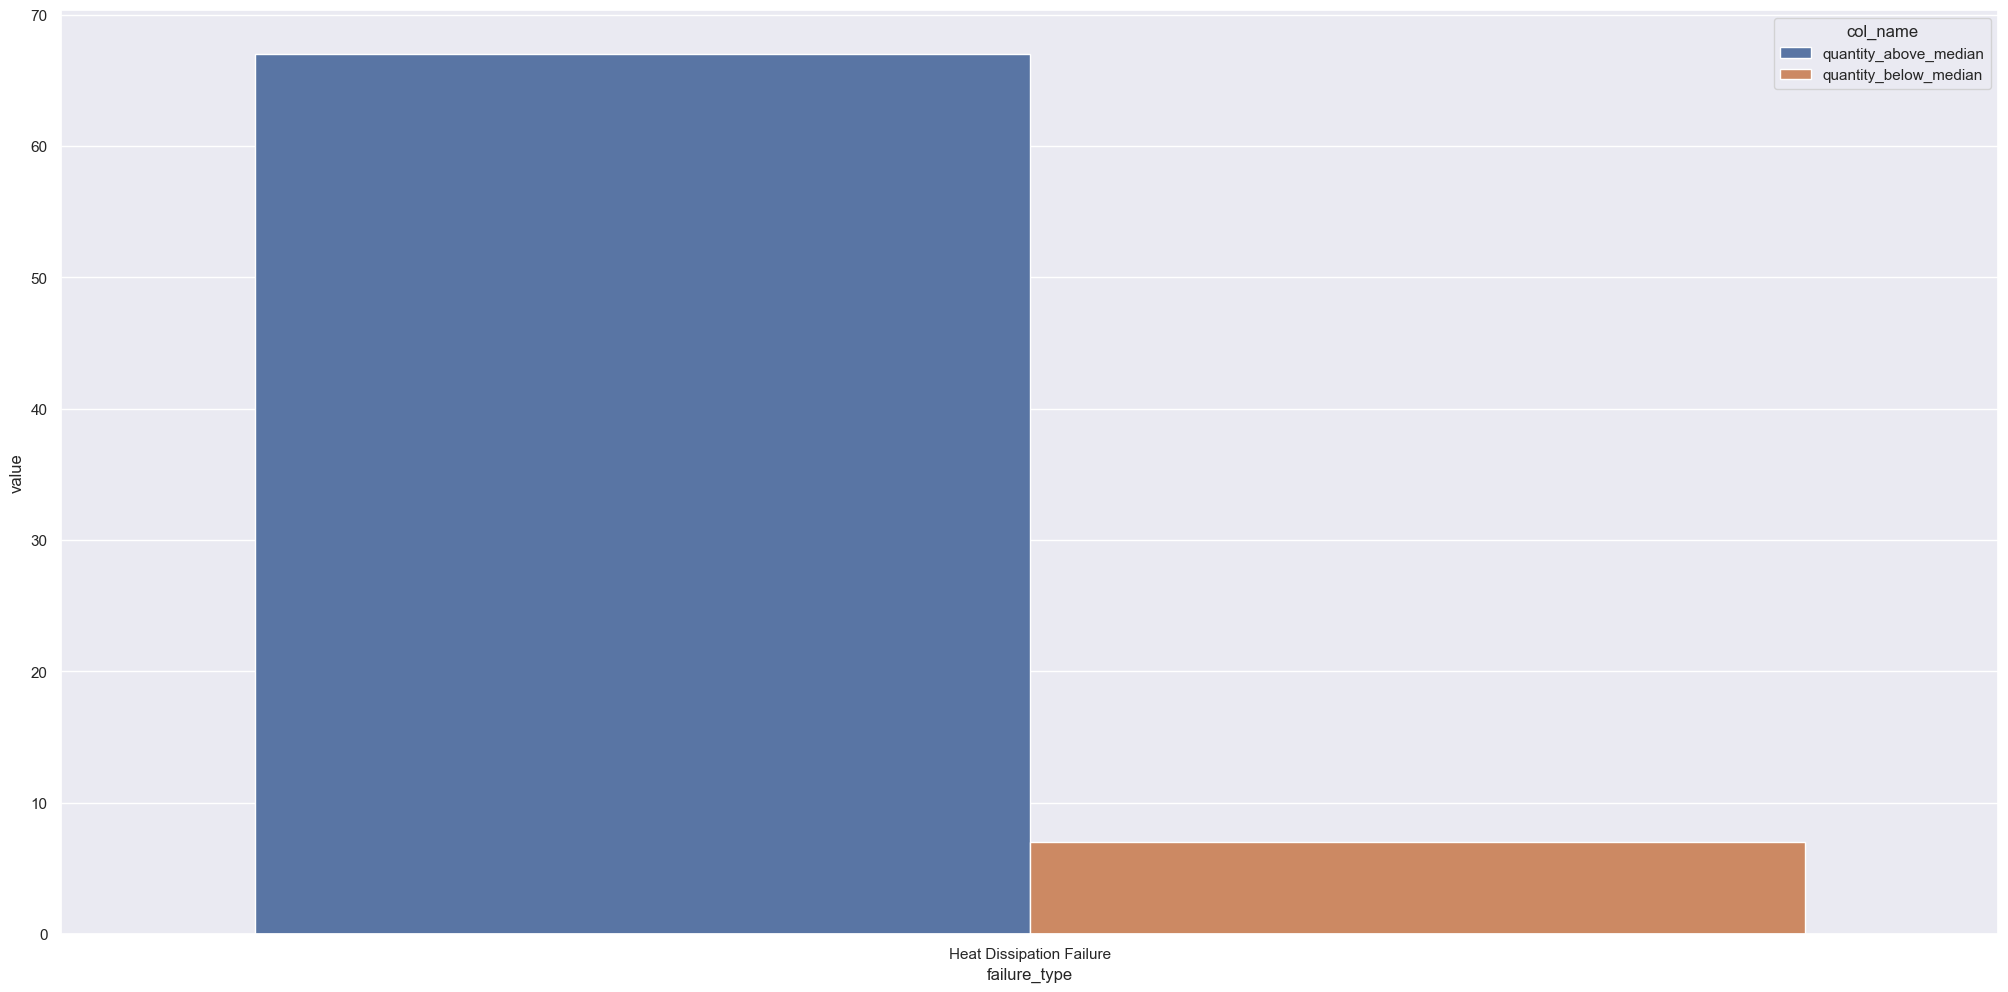

In [45]:

melted = aux.melt(id_vars='failure_type', value_vars=['quantity_above_median', 'quantity_below_median'], var_name='col_name', value_name='value')
sns.barplot(x='failure_type', y='value', hue='col_name', data=melted[melted['failure_type'] == 'Heat Dissipation Failure']);

**Falso, máquinas cuja temperatura de processo está acima da mediana apresenta aproximadamente 9,6 vezes mais falhas de dissipação do que as que estão abaixo da mediana**

### h05: Máquinas que trabalham com rotação acima do 90 percentil apresentam mais falhas de qualquer tipo

In [46]:
#criando dataframe com os dados significantes para a hipotese
h5 = df1[['rotational_speed_rpm','failure_type']]

# defindo a variavel auxiliar 'failure' para agrupar todos os tipo de falhas
h5['failure'] = (h5['failure_type'] != 'No Failure').astype(int)

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\1014297803.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h5['failure'] = (h5['failure_type'] != 'No Failure').astype(int)


In [47]:
# valor do percentil 90 da rotação
rotation_perc_90 = h5['rotational_speed_rpm'].quantile(0.90)

#função auxiliar
aux_func = lambda x: 'above' if x > rotation_perc_90 else 'bellow'

#variavel auxiliar para identificar as maquinas que está com valores abaixo e acima do percentil 90
h5['rotation_perc_90'] = h5['rotational_speed_rpm'].apply(aux_func)

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\1550392921.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h5['rotation_perc_90'] = h5['rotational_speed_rpm'].apply(aux_func)


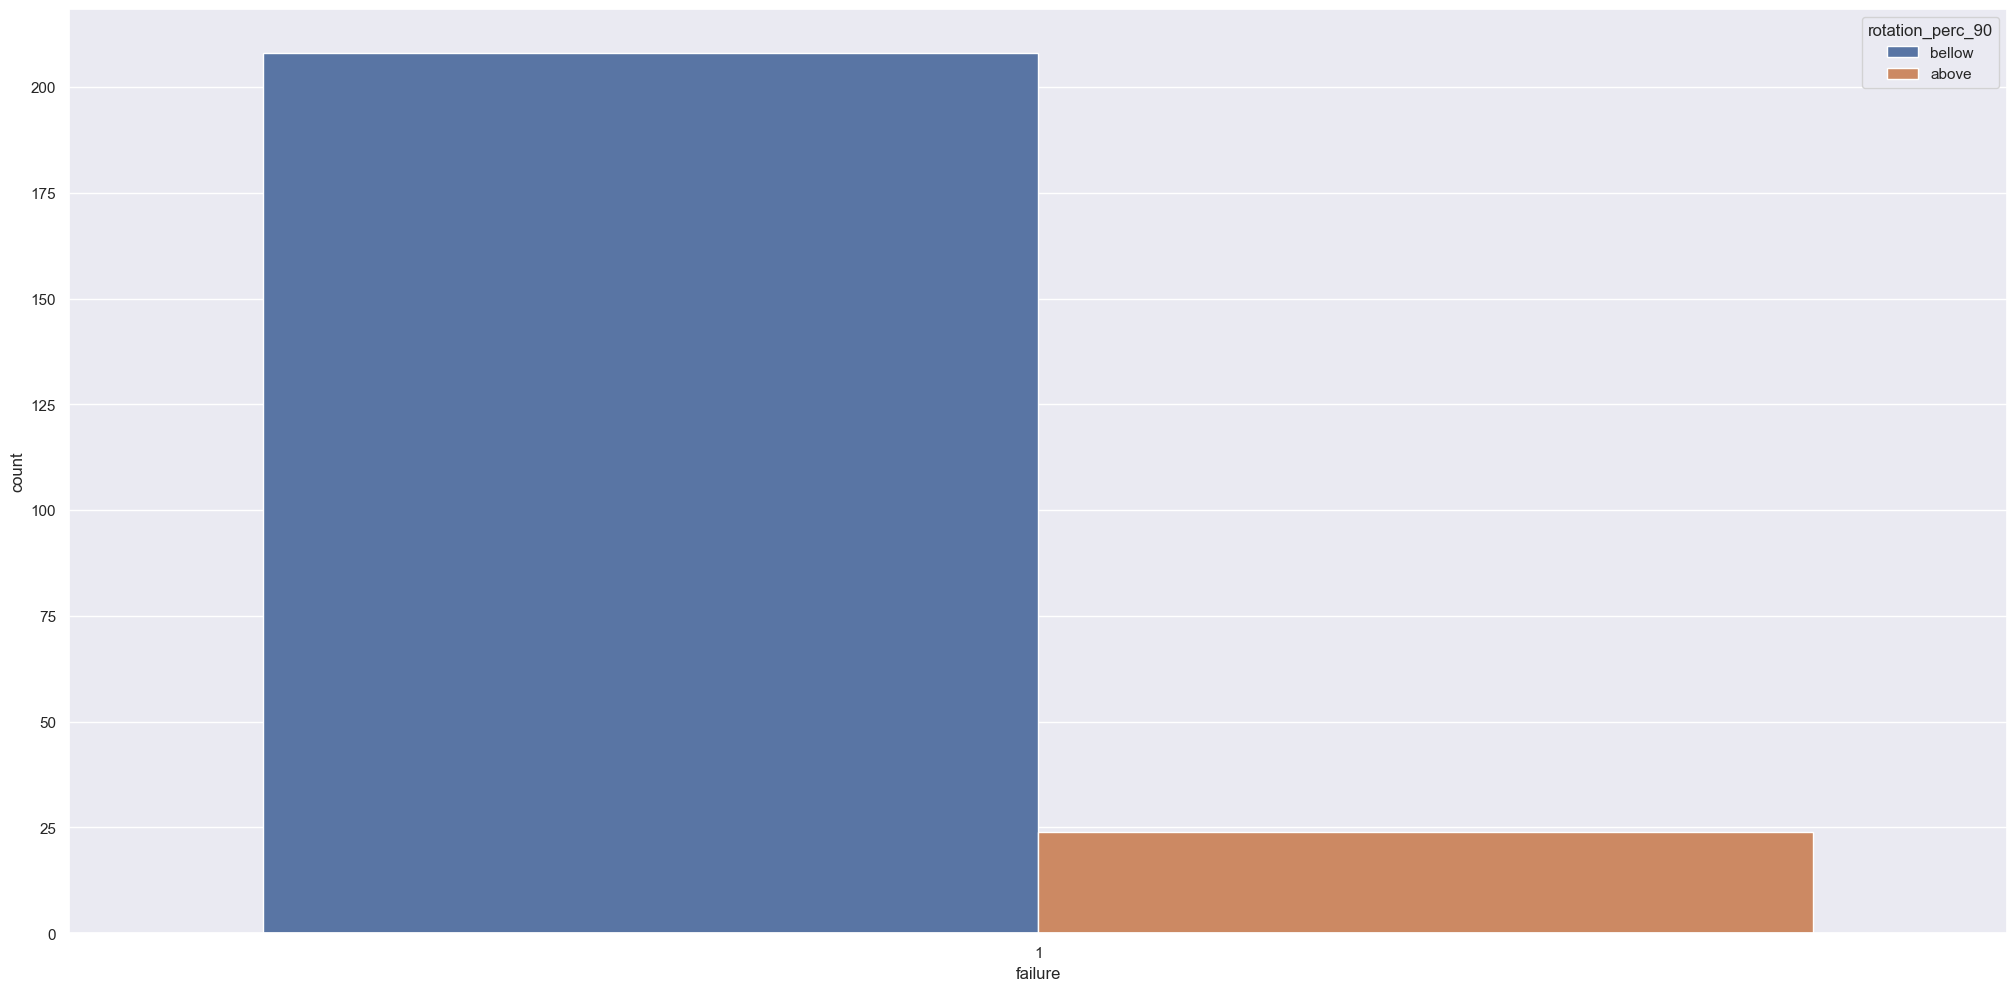

In [48]:
#plotando os valores de comporação entre  máquinas com falhas 
sns.countplot(x='failure',hue='rotation_perc_90',data=h5[h5['failure']==1]);

In [49]:
#valores númericos de comparação de falhas
h5[['failure','rotation_perc_90']].groupby(['failure','rotation_perc_90']).size()

failure  rotation_perc_90
0        above                641
         bellow              5794
1        above                 24
         bellow               208
dtype: int64

**Falso, máquinas que funcionam com rotação acima do percental .90 não possuem mais falhas**

### h06: Máquinas que trabalham com rotação acima do 80 percentil apresentão mais falhas de sobrecarga

In [50]:
#criando dataframe com os dados significantes para a hipotese
h6 = df1[['rotational_speed_rpm','failure_type']]

# valor do percentil 90 da rotação
rotation_perc_80 = h6['rotational_speed_rpm'].quantile(0.80)

#função auxiliar
aux_func = lambda x: 'above' if x > rotation_perc_80 else 'bellow'

#variavel auxiliar para identificar as maquinas que está com valores abaixo e acima do percentil 90
h6['rotation_perc_80'] = h6['rotational_speed_rpm'].apply(aux_func)

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\2476747077.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h6['rotation_perc_80'] = h6['rotational_speed_rpm'].apply(aux_func)


In [51]:
h6 = h6[['rotation_perc_80','failure_type']].groupby(['rotation_perc_80','failure_type']).size().reset_index()

In [52]:
h6

,rotation_perc_80,failure_type,0
0,above,No Failure,1295
1,above,Power Failure,18
2,above,Random Failures,1
3,above,Tool Wear Failure,10
4,bellow,Heat Dissipation Failure,75
5,bellow,No Failure,5140
6,bellow,Overstrain Failure,52
7,bellow,Power Failure,45
8,bellow,Random Failures,11
9,bellow,Tool Wear Failure,20


**Falso, ao contrário do que se pensava as falhas por esforço excessivo estão localizadas em níveis de rotação abaixo do percentil 80**

### h07: Máquinas que trabalham com torque acima do 95 percentil apresentão 2x mais falhas de energia

In [53]:
#criando dataframe com os dados significantes para a hipotese
h7 = df1[['torque_nm','failure_type']]

# valor do percentil 90 da rotação
torc_perc_95 = h7['torque_nm'].quantile(0.95)

#função auxiliar
aux_func = lambda x: 'above' if x > torc_perc_95 else 'bellow'

#variavel auxiliar para identificar as maquinas que está com valores abaixo e acima do percentil 90
h7['torc_perc_95'] = h7['torque_nm'].apply(aux_func)

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\1379820623.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h7['torc_perc_95'] = h7['torque_nm'].apply(aux_func)


In [54]:
h7 = h7[['torc_perc_95','failure_type']].groupby(['torc_perc_95','failure_type']).size().reset_index()

In [55]:
h7

,torc_perc_95,failure_type,0
0,above,Heat Dissipation Failure,18
1,above,No Failure,238
2,above,Overstrain Failure,24
3,above,Power Failure,45
4,above,Random Failures,2
5,bellow,Heat Dissipation Failure,57
6,bellow,No Failure,6197
7,bellow,Overstrain Failure,28
8,bellow,Power Failure,18
9,bellow,Random Failures,10


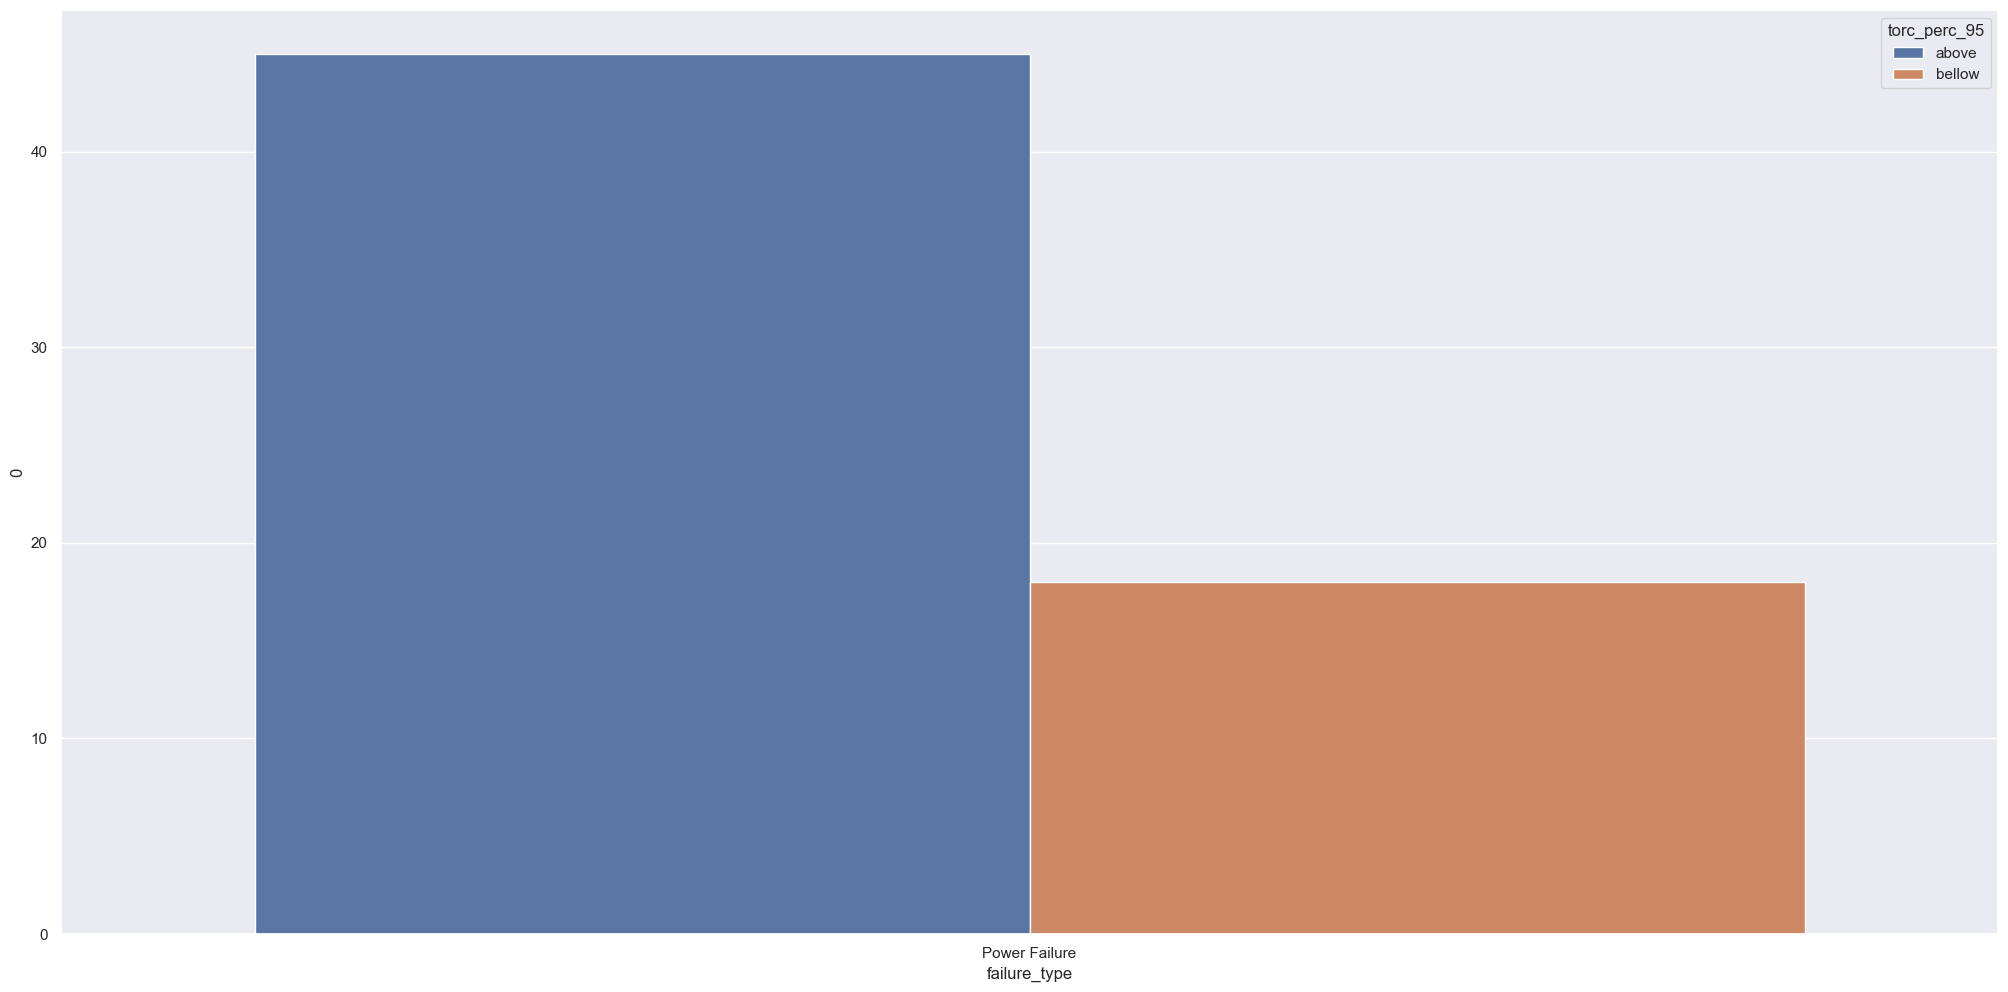

In [56]:
sns.barplot(x='failure_type',y=0,hue='torc_perc_95',data=h7[h7['failure_type']=='Power Failure']);

**Falso, Máquinas que trabalham com torque acima do percentil 95 apresentam 2,5 vezes mais falhas de energia que aquelas abaixo**

### h08: Máquinas que apresentão falha de energia possuem torque acima da média geral e rotação abaixo da média geral

In [57]:
#criando dataframe com os dados significantes para a hipotese
h8 = df1.loc[df1['failure_type'] == 'Power Failure',['rotational_speed_rpm', 'torque_nm']]


In [58]:
#calculando média e mediana
h8.agg(['mean','median']).T

,mean,median
rotational_speed_rpm,1712.857143,1386.0
torque_nm,51.080952,65.3


**Falso, maquinas que apresentão falhas de energia possuem tanto torque como rotação acima da média geral. Podendo indicar que alto torque e alta rotação influenciam nesse tipo de falha**

### h09: Máquinas que trabalham com todos os atributos continuos abaixo da média não apresentam falhas

In [59]:
h9 = df1[['type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type']]

In [60]:
h9 = h9[(h9['air_temperature_k'] < h9['air_temperature_k'].mean()) & (h9['process_temperature_k']<h9['process_temperature_k'].mean()) & 
   (h9['rotational_speed_rpm']<h9['rotational_speed_rpm'].mean()) & (h9['torque_nm']<h9['torque_nm'].mean()) & (h9['tool_wear_min'] < h9['tool_wear_min'].mean())]

In [61]:
h9['failure_type'].value_counts()

No Failure    166
Name: failure_type, dtype: int64

**Verdadeiro, máquinas com atributos continuos que operam abaixo da média não apresentam falhas**

### h010: Máquinas que trabalham com desgaste de ferramenta acima do 70. percentil apresentão mais falha de desgaste

In [62]:
h10 = df1[['tool_wear_min','failure_type']]

tool_perc_70 = h10['tool_wear_min'].quantile(0.70)

#função auxiliar
aux_func = lambda x: 'above' if x > tool_perc_70  else 'bellow'

#variavel auxiliar para identificar as maquinas que está com valores abaixo e acima do percentil 90
h10['tool_perc_70'] = h10['tool_wear_min'].apply(aux_func)

C:\Users\Lavin\AppData\Local\Temp\ipykernel_15916\2172073074.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h10['tool_perc_70'] = h10['tool_wear_min'].apply(aux_func)


In [63]:
h10[['tool_perc_70','failure_type']].groupby(['tool_perc_70','failure_type']).size().reset_index()

,tool_perc_70,failure_type,0
0,above,Heat Dissipation Failure,25
1,above,No Failure,1849
2,above,Overstrain Failure,52
3,above,Power Failure,15
4,above,Random Failures,6
5,above,Tool Wear Failure,30
6,bellow,Heat Dissipation Failure,50
7,bellow,No Failure,4586
8,bellow,Power Failure,48
9,bellow,Random Failures,6


**Verdadeiro, Máquinas que possuem valores de desgaste de ferramenta acima do percentil 70 agrupam todas as falhas por desgaste de ferramenta**

###  Análise Multivariada

**Analise de como as variáveis se comportam entre si, como a variável alvo é categorica com muitas categorias ela não será incluida no estudo de correlação por estatisticamente os método não abrangerem seu comportamento**

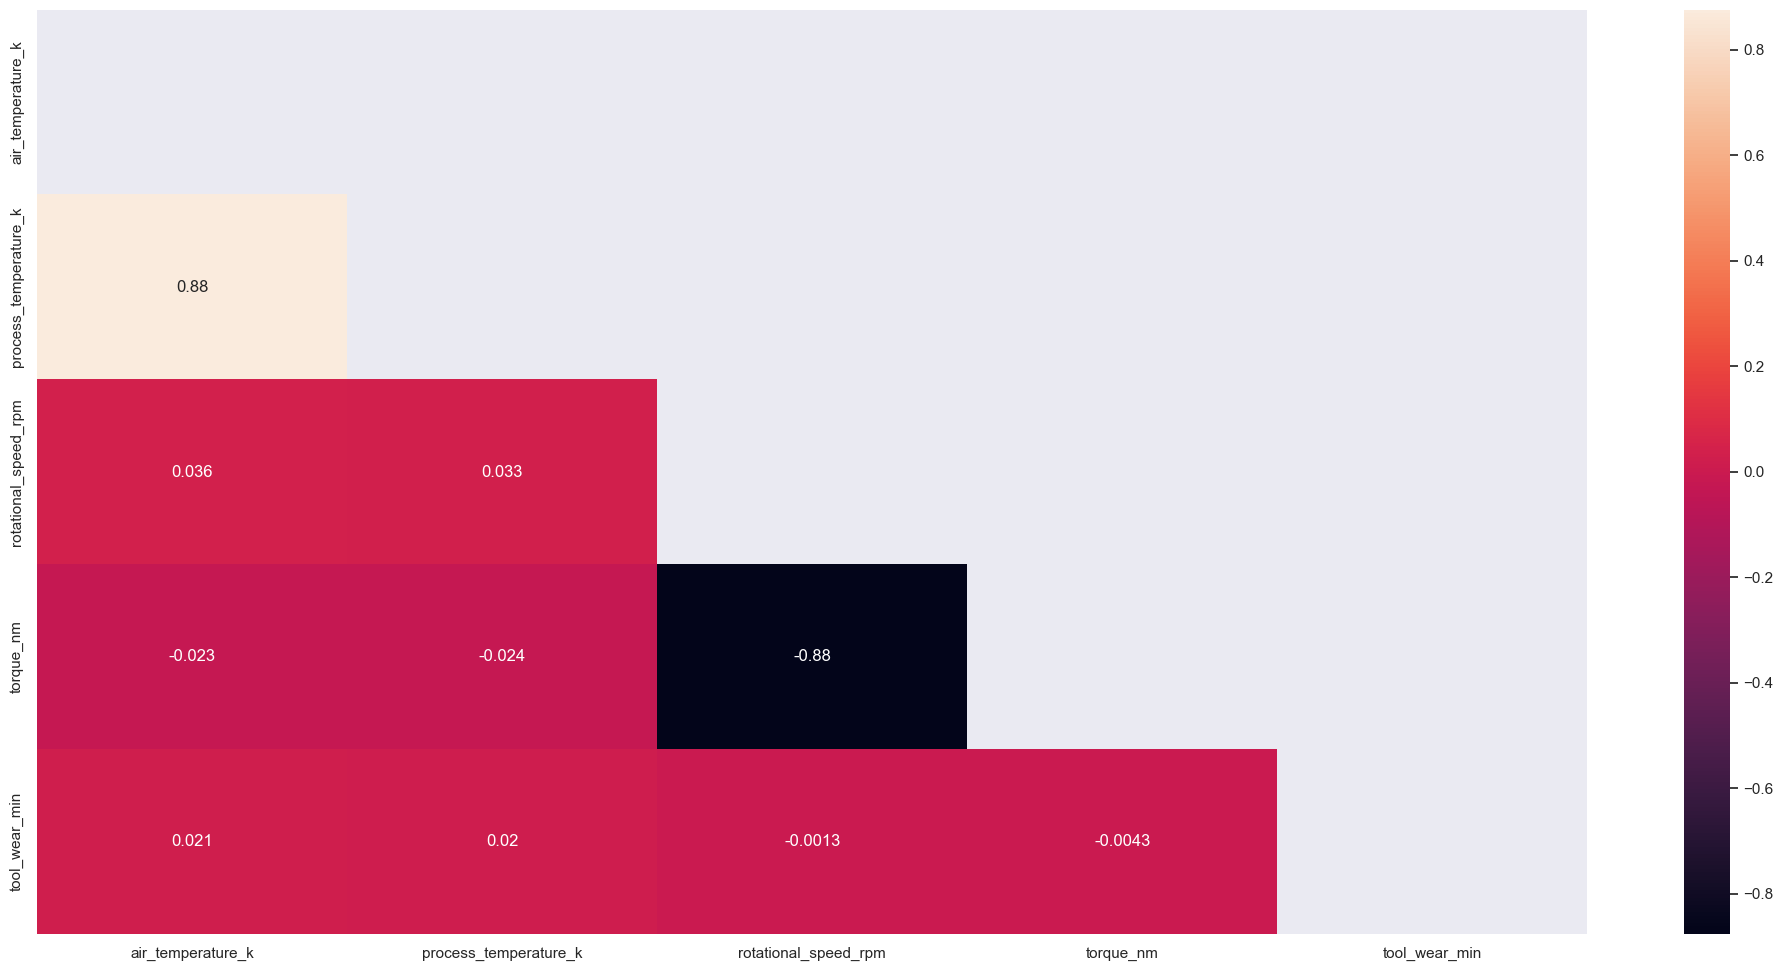

In [64]:
coorelation = num_attribures.corr(method='pearson')
matrix = np.triu(coorelation)
sns.heatmap(coorelation,annot=True,mask=matrix);

**os atributos 'air_temperature_k' e 'process_temperature_k' posssuem alta correlação oque pode significar o possibilidade de exclusão de um por não agregar informações ao modelo, será decidido na parte de feature selection**

# 5.0 Data preparation 

Preparação dos dados para melhor se adequarem aos modelos

In [152]:
df2 = df1.copy()

## Rescaling

Robust scalar - como os atributos abaixo possuem valores de outilers será aplicado o 'robust scaler'

'rotational_speed_rpm', 
'torque_nm',

min-max scaler - os atributos abaixo naão possuem outliers então  será aplicado o 'Min-Max scaler'

'air_temperature_k',
'process_temperature_k', 
'tool_wear_min'

In [153]:
mms = MinMaxScaler()
rs = RobustScaler()

#robustscaler
df2['rotational_speed_rpm'] = rs.fit_transform(df2[['rotational_speed_rpm']])
pickle.dump(rs,open(path_local + 'src/features/rotational_speed_rpm_scaler.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)
df2['torque_nm'] = rs.fit_transform(df2[['torque_nm']])
pickle.dump(rs,open(path_local + 'src/features/torque_nm_scaler.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)


#min-max scaler

df2['air_temperature_k'] = mms.fit_transform(df2[['air_temperature_k']])
pickle.dump(mms,open(path_local + 'src/features/air_temperature_k_scaler.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)
df2['process_temperature_k'] = mms.fit_transform(df2[['process_temperature_k']])
pickle.dump(mms,open(path_local + 'src/features/process_temperature_k_scaler.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)
df2['tool_wear_min'] = rs.fit_transform(df2[['tool_wear_min']])
pickle.dump(mms,open(path_local + 'src/features/tool_wear_min_scaler.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)


##  Encoding

Para a variável 'type' será aplicado o frequência encoding para presenvar a proporção dos typos de máquinas presentes

e 'failure_type' será aplicado o labelenconig

In [154]:
# frequêncy encoding
freq = np.round_(df2['type'].value_counts(normalize=True),2).to_dict()
df2['type'] = df2['type'].map(freq)

In [155]:
#label encoding
le = LabelEncoder()
df2['failure_type'] = le.fit_transform(df2['failure_type'])
pickle.dump(le,open(path_local + 'src/features/encoding_failure_type.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)

In [156]:
df2.to_csv(path_local + 'data/processed/df2.csv',index=False)

# 6.0 Feature selection 

In [157]:
df3 = pd.read_csv(path_local + 'data/processed/df2.csv')

In [158]:
df3.dtypes

udi                        int64
product_id                object
type                     float64
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm     float64
torque_nm                float64
tool_wear_min            float64
failure_type               int64
dtype: object

##  Boruta

In [159]:
#dividindo em treino e teste
X_train = df3.drop(columns=['udi', 'product_id'])
y_train = X_train['failure_type']
X_train = X_train.drop(columns='failure_type')

In [160]:
# training and test datase for boruta
x_train_n = X_train.values
y_train_n = y_train.values.ravel()


# RandonForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

In [161]:
# define boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	17 / 

In [162]:
# cols_selected = boruta.support_.tolist()

# x_train_fs = X_train
# cols_selected_boruta = x_train_fs.iloc[:,cols_selected]

# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [163]:
cols_selected_boruta_final = ['rotational_speed_rpm', 'torque_nm', 'tool_wear_min']

##  Feature importance

In [164]:
etf = ExtraTreesClassifier(n_estimators=300,max_features='sqrt',random_state=42,n_jobs=-1)

In [165]:
etf.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [166]:
importances = etf.feature_importances_

In [167]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        etf.estimators_],
                                        axis = 0)
indices = np.argsort(etf.feature_importances_)[::-1]

In [168]:
etf.feature_importances_ 

array([0.03164947, 0.15260898, 0.12675771, 0.21217998, 0.29244156,
       0.18436231])

In [169]:
# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( X_train, etf.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
df = df.sort_values( 'importance', ascending=False )
df

Feature ranking:


,feature,importance
0,torque_nm,0.292442
0,rotational_speed_rpm,0.212180
0,tool_wear_min,0.184362
0,air_temperature_k,0.152609
0,process_temperature_k,0.126758
0,type,0.031649


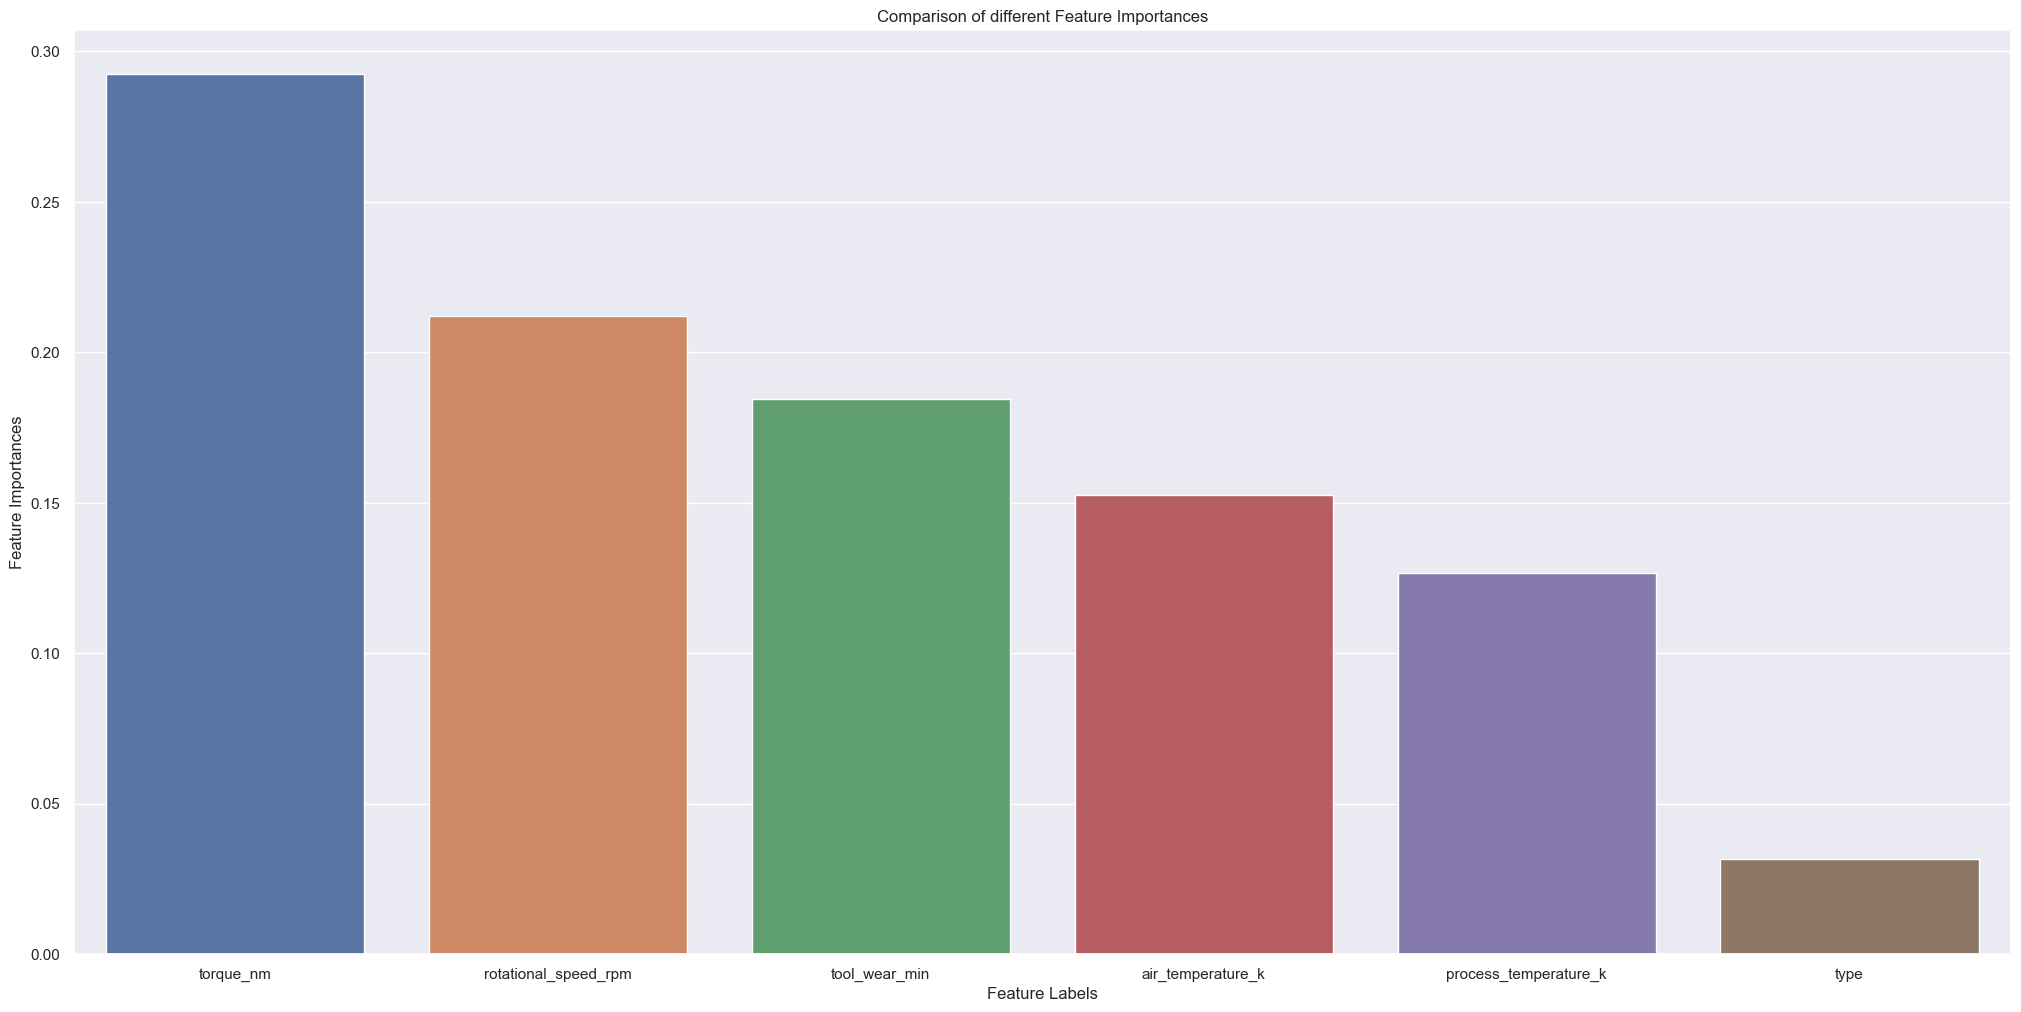

In [170]:
sns.barplot(x='feature',y='importance',data=df)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

**Com os resultados do boruta, feature importance e as análises feitas previamente de todos os atributos apenas o 'type' será excluido para o treinamento do modelo**

In [174]:
df3.columns

Index(['udi', 'product_id', 'type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type'],
      dtype='object')

In [176]:
cols_select_final = ['product_id','air_temperature_k','process_temperature_k', 'rotational_speed_rpm', 'torque_nm','tool_wear_min', 'failure_type']

In [177]:
df_train_processed = df3[cols_select_final]

In [180]:
#df_train_processed.to_csv(path_local +'data/processed/df_train_processed.csv',index=False)